# Import

In [1]:
# Manipulando datos y preprocesamiento
import pandas as pd
import numpy as np
import csv
from yaml.loader import SafeLoader
import json
import yaml
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler 
import glob                                     # trae las rutas de archivo de una ruta especifica
import os                                       # trae las rutas de los archivos
from sklearn.pipeline import make_pipeline
from skimpy import clean_columns
import missingno as msno
import pickle


# librería que muestra los warning 
import warnings   
warnings.filterwarnings("ignore", category=DeprecationWarning) 
plt.style.use("seaborn")

# Import psycopg2
from psycopg2 import connect, extensions, sql
from sqlalchemy import create_engine

# Librerías para reporte de métricas
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

# Funciones custom
from lib.functDescriptiveAnalysis import inspectDataFrameDA, countNaNDA
from lib.functCleanData import convert_float, whitespaceRemover
from lib.functReportGraficas import plot_importance, resultados_modelo
from lib.functModels import get_scaled_matrix, fit_or_load_model, calcular_error_modelo


# Módulos de modelos
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV          # Modelo 1 
from sklearn.linear_model import SGDRegressor          # Modelo 2 
from sklearn.ensemble import GradientBoostingRegressor # Modelo 3
from sklearn.tree import DecisionTreeRegressor         # Modelo 4
from sklearn.ensemble import RandomForestRegressor     # Modelo 5




# Carga del DataFrame

In [2]:
# Generamos un Dataframe con los datos necesarios
df = pickle.load(open('data/output/dataset_pre_modelacion.plk', 'rb'))
with pd.option_context("display.max_columns", None):
    display(df.head(n = 5))

,order_id,lat_order,lng_order,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes,actual_reception_time,promised_delivery_time,total_minutes_td,order_time,model_1_dt_time,model_1_time,store,lat_store,lng_store,shopper_id_picker,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,shopper_id_driver,seniority_driver,found_rate_driver,picking_speed_driver,accepted_rate_driver,rating_driver,total_product,real_total_unit,real_total_kg,real_without_product,total_unit,total_kg,distancia,hora_de_pedido_aprox,horario
0,6abd5e28d01b7c733fe37485294235dc,18.22114,-10.03139,2,13:00:00,12:00:15,False,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,91.800861,1900-01-01 12:00:15,1900-01-01 13:00:00,0 days 01:31:48.051660,1900-01-01 10:28:26.948340000,0 days 02:31:33.051660,151.550861,60e4c4e1c1a8bc79123738227b9d0b08,18.23190,-10.03035,09bb5bfe76adbb474dddbdd111a51623,ADVANCED,0.86,1.56,1.00,4.68,09bb5bfe76adbb474dddbdd111a51623,ADVANCED,0.86,1.56,1.00,4.68,27.0,18.0,6.245,1.0,19.0,5.722,1.201490,10,HorarioPunta
1,0d37a1eea001f01b40232ffd496ff663,18.17771,-10.03570,2,13:00:00,10:28:10,False,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599732,1900-01-01 10:28:10,1900-01-01 13:00:00,0 days 03:26:35.983919999,1900-01-01 07:01:34.016080001,0 days 05:58:25.983919999,358.433065,387d4a5b65cf4bf00ad805c4b00eed01,18.16396,-10.03289,c4c722114a82fa21654e57e9636d68b0,ADVANCED,0.85,1.14,1.00,4.76,c4c722114a82fa21654e57e9636d68b0,ADVANCED,0.85,1.14,1.00,4.76,103.0,114.0,40.614,20.0,150.0,39.562,1.557488,7,HorarioValle
2,528428e9b9eb5d3bd0dbdd8da692b087,18.26683,-10.03175,2,11:00:00,10:40:50,False,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458001,1900-01-01 10:40:50,1900-01-01 11:00:00,0 days 01:33:27.480060,1900-01-01 09:07:22.519940000,0 days 01:52:37.480060,112.624668,0fae7b61265bc7ca4ce4d81440b62501,18.24565,-10.03324,e15c7a67d0ea9a54dffb410bc1d8528b,INTERMEDIATE,0.83,2.03,1.00,4.96,e15c7a67d0ea9a54dffb410bc1d8528b,INTERMEDIATE,0.83,2.03,1.00,4.96,6.0,6.0,0.000,0.0,6.0,0.000,2.360362,9,HorarioPunta
3,d3f7be6d64eae7405b7bf024e04807a2,18.24888,-10.03226,2,10:00:00,9:41:47,False,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,124.778761,1900-01-01 09:41:47,1900-01-01 10:00:00,0 days 02:04:46.725660,1900-01-01 07:37:00.274340000,0 days 02:22:59.725660,142.995428,60e4c4e1c1a8bc79123738227b9d0b08,18.23190,-10.03035,d1f0bd4b237c1358f09db22076b940e7,INTERMEDIATE,0.86,2.06,0.92,4.92,d1f0bd4b237c1358f09db22076b940e7,INTERMEDIATE,0.86,2.06,0.92,4.92,17.0,18.0,19.805,1.0,20.0,18.300,1.898837,7,HorarioValle
4,e0ad6533b6cd9a382ec6c1d473c5036c,18.22911,-10.03226,2,11:00:00,10:07:53,False,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321208,1900-01-01 10:07:53,1900-01-01 11:00:00,0 days 02:10:19.272480,1900-01-01 07:57:33.727520000,0 days 03:02:26.272480,182.437875,452ae015bf846e1d2932b7ea15720d64,18.23159,-10.03145,06a71e8ab0c6db5ce22a4689fd76a3f4,ADVANCED,0.86,1.89,1.00,4.92,06a71e8ab0c6db5ce22a4689fd76a3f4,ADVANCED,0.86,1.89,1.00,4.92,44.0,28.0,11.575,3.0,31.0,7.721,0.288728,7,HorarioValle


In [3]:
# Se eliminan aquellas columnas de poca relevancia para el modelo
df_modelo = df.copy()
df_modelo = df_modelo.drop(columns = ['lat_order', 'lng_order', 'promised_time',
       'actual_time', 'picker_id', 'driver_id',
       'actual_reception_time', 'promised_delivery_time', 'shopper_id_driver',
       'total_minutes_td', 'order_time', 'model_1_dt_time', 'model_1_time',
       'store', 'lat_store', 'lng_store', 'shopper_id_picker',
        'real_without_product', 'real_total_kg', 'real_total_unit'])
df_modelo.head()

,order_id,dow,on_demand,store_branch_id,total_minutes,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,...,found_rate_driver,picking_speed_driver,accepted_rate_driver,rating_driver,total_product,total_unit,total_kg,distancia,hora_de_pedido_aprox,horario
0,6abd5e28d01b7c733fe37485294235dc,2,False,0dc6fb5924a8b917bc641666ed02663c,91.800861,ADVANCED,0.86,1.56,1.00,4.68,...,0.86,1.56,1.00,4.68,27.0,19.0,5.722,1.201490,10,HorarioPunta
1,0d37a1eea001f01b40232ffd496ff663,2,False,2bbf833e689d24b697f1f3529c3f3c4b,206.599732,ADVANCED,0.85,1.14,1.00,4.76,...,0.85,1.14,1.00,4.76,103.0,150.0,39.562,1.557488,7,HorarioValle
2,528428e9b9eb5d3bd0dbdd8da692b087,2,False,8d891dfc0e29d744c15c18adced74a68,93.458001,INTERMEDIATE,0.83,2.03,1.00,4.96,...,0.83,2.03,1.00,4.96,6.0,6.0,0.000,2.360362,9,HorarioPunta
3,d3f7be6d64eae7405b7bf024e04807a2,2,False,0dc6fb5924a8b917bc641666ed02663c,124.778761,INTERMEDIATE,0.86,2.06,0.92,4.92,...,0.86,2.06,0.92,4.92,17.0,20.0,18.300,1.898837,7,HorarioValle
4,e0ad6533b6cd9a382ec6c1d473c5036c,2,False,afd0a7b8d546fcc697bb93a5934b65c3,130.321208,ADVANCED,0.86,1.89,1.00,4.92,...,0.86,1.89,1.00,4.92,44.0,31.0,7.721,0.288728,7,HorarioValle


In [4]:
# Las variables dow y hora pedido son transformadas o object para que get_dummies funcione correctamente
variables_numericas_recodificar = ["dow", "hora_de_pedido_aprox"]
for col in variables_numericas_recodificar:
    df_modelo[col] = 'c' + df_modelo[col].astype(str) 
df_modelo.head()

,order_id,dow,on_demand,store_branch_id,total_minutes,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,...,found_rate_driver,picking_speed_driver,accepted_rate_driver,rating_driver,total_product,total_unit,total_kg,distancia,hora_de_pedido_aprox,horario
0,6abd5e28d01b7c733fe37485294235dc,c2,False,0dc6fb5924a8b917bc641666ed02663c,91.800861,ADVANCED,0.86,1.56,1.00,4.68,...,0.86,1.56,1.00,4.68,27.0,19.0,5.722,1.201490,c10,HorarioPunta
1,0d37a1eea001f01b40232ffd496ff663,c2,False,2bbf833e689d24b697f1f3529c3f3c4b,206.599732,ADVANCED,0.85,1.14,1.00,4.76,...,0.85,1.14,1.00,4.76,103.0,150.0,39.562,1.557488,c7,HorarioValle
2,528428e9b9eb5d3bd0dbdd8da692b087,c2,False,8d891dfc0e29d744c15c18adced74a68,93.458001,INTERMEDIATE,0.83,2.03,1.00,4.96,...,0.83,2.03,1.00,4.96,6.0,6.0,0.000,2.360362,c9,HorarioPunta
3,d3f7be6d64eae7405b7bf024e04807a2,c2,False,0dc6fb5924a8b917bc641666ed02663c,124.778761,INTERMEDIATE,0.86,2.06,0.92,4.92,...,0.86,2.06,0.92,4.92,17.0,20.0,18.300,1.898837,c7,HorarioValle
4,e0ad6533b6cd9a382ec6c1d473c5036c,c2,False,afd0a7b8d546fcc697bb93a5934b65c3,130.321208,ADVANCED,0.86,1.89,1.00,4.92,...,0.86,1.89,1.00,4.92,44.0,31.0,7.721,0.288728,c7,HorarioValle


In [5]:
# Senoritypicker y senioritydriver son transformadas en niveles
df_modelo['seniority_picker'] = df_modelo['seniority_picker'].replace(
    ['ADVANCED', 'INTERMEDIATE', 'REVIEW', 'BEGINNER'],
    [3, 2, 1, 0]
)

df_modelo['seniority_driver'] = df_modelo['seniority_driver'].replace(
    ['ADVANCED', 'INTERMEDIATE', 'REVIEW', 'BEGINNER'],
    [3, 2, 1, 0]
)

In [6]:
# Generamos los codificación dummies, para generar el dataframe que se ocupara en el modelo
for col, dtype in df_modelo.dtypes.iteritems():
    if dtype == 'O' and col != 'order_id':
        dummies = pd.get_dummies(df_modelo[col], prefix=col, drop_first=True)
        df_modelo = pd.concat([df_modelo, dummies], axis=1).drop(columns=[col])

In [7]:
with pd.option_context("display.max_columns", None):
    display(df_modelo.head(n = 5))

,order_id,on_demand,total_minutes,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,seniority_driver,found_rate_driver,picking_speed_driver,accepted_rate_driver,rating_driver,total_product,total_unit,total_kg,distancia,dow_c1,dow_c2,dow_c3,dow_c4,dow_c5,dow_c6,store_branch_id_02020427c72aa211602ead141160a9eb,store_branch_id_0302e4778cdaf296d9b69564e6296b6b,store_branch_id_0309659a74b54b7933aa6c0571497d9b,store_branch_id_0a5262149db2b5b849da2128cee09358,store_branch_id_0cdeb3c8700028cdf750409d66e354da,store_branch_id_0dc6fb5924a8b917bc641666ed02663c,store_branch_id_144aa59c494a4450656ced49ea400d1b,store_branch_id_15bf16e04b6f5e730f38a7c6a4b47f21,store_branch_id_1679232b44bbe5c756a345fff42acd36,store_branch_id_16e537c9d1bf9a530aea9af2c8020f52,store_branch_id_175d039c07ea5128fa4e5ec01902a710,store_branch_id_1ab8f7f99a1730f85df0b9e503c1a319,store_branch_id_1f660027cb64313d072c844d9fdc31e4,store_branch_id_1fab95c4c6d7555f391a045b4881b423,store_branch_id_1fc727dd540d924d2370b4d6ec0149fd,store_branch_id_215f4c85edb5fd23b7b095104bc34cb2,store_branch_id_21a6aed891ee4844c56a063a79a50208,store_branch_id_22dcadd55bcd012e63ececc69c55bb74,store_branch_id_258f4c26a82a5239920a082ffe23cfc4,store_branch_id_25b1e6be606fe62b5770a5bfaf25bfec,store_branch_id_2771c8bdd43c6357cce12f9d946dcf75,store_branch_id_2aa560c85aeb4213b9af8bdd05805b91,store_branch_id_2bbf833e689d24b697f1f3529c3f3c4b,store_branch_id_2d69acabaafd2516eeffd3c69b3c1328,store_branch_id_37d89853e51879008c528640f48cf420,store_branch_id_383930af40caaa13760a10a9d6f418ab,store_branch_id_3ad5bfb1ba9eb8e0b76bdbaf0d8e6a3a,store_branch_id_3d8ac35d74ad2f875847247ebfd716ca,store_branch_id_3dd9ae393aa5327edfb27388758436bd,store_branch_id_3ddd4c29cab4178d89d549c6ba65c236,store_branch_id_3ecb75411e187833a1b822a0eaa255fa,store_branch_id_41ca3a65599fb02ab0d0cdd23da1e922,store_branch_id_41d9a054007bfce5cd838d2f9b2d7db3,store_branch_id_49b7d60d6095a9f1129ce798102b62f4,store_branch_id_4a07fa0a140101e2270d5b95e7583401,store_branch_id_4a07fce9f9c16c911b8821717905a0d3,store_branch_id_4d4f7045619dd94fd41ddb64fbccf9f5,store_branch_id_4e1e1ec3892a5523e0d139f9aff41301,store_branch_id_4f01884af565f4d2df35419e09cf58d0,store_branch_id_539fefbf8bd77f800d05b04cce7b0f07,store_branch_id_57eb965a3305343348a2c179a610dce1,store_branch_id_585d8f4f36bc74acf0fc1fae7913b404,store_branch_id_58dc6da0edd08253743c7ed41280bcfc,store_branch_id_5a6dd51ef5ed276079b6a102d4ceb8f6,store_branch_id_6045691f87544c937a09d350d42eb3ba,store_branch_id_61c357d4bbf6b7421032a467b616f879,store_branch_id_6447951cd071f6f045fd4e6194920926,store_branch_id_64a244c174e03776c96385894252f149,store_branch_id_64f6f160b2937501d7627285c5994b38,store_branch_id_69803373c7d9ae282a73c00e69f119b4,store_branch_id_6cd78596c7bf5ef34f3d5c197ef2ee8e,store_branch_id_6ff95b527827f48461836b1c64f48771,store_branch_id_70d57522d7e36733fe5015e687bea6f3,store_branch_id_72238a1ce4cf02d9744926a5c8ac4368,store_branch_id_75d034354b7c54e65b50193f8f987386,store_branch_id_762276b0a3d020a8393c26579a6e5e7f,store_branch_id_7a44728dc60bafc53140a9f5ef7e4e75,store_branch_id_7b571744f2c64bcff08d971a64584874,store_branch_id_7c5c15309c5aecf4009261f4de305f6b,store_branch_id_821dc9d74061fe7654b9ec20e574022d,store_branch_id_82862bb4ff9734b6f8fee2dcde6be96f,store_branch_id_83c1570496a3ead7f4202afb827d59bb,store_branch_id_850fc42b029db68d97f0aea6a8babe36,store_branch_id_86e6e48d0cb57f794b0c48162409fa74,store_branch_id_88c1e4665f49718496981b3228416f35,store_branch_id_8a0d17a3597b726e5ea4962c78f5715a,store_branch_id_8ade020f4c949f4e00ca91082d63a17e,store_branch_id_8d891dfc0e29d744c15c18adced74a68,store_branch_id_8f21cfda17b340aeee062220d0bee8e5,store_branch_id_90d3e898952320088d3de585f75a4873,store_branch_id_938420c4980439b9655c61c85b81333e,store_branch_id_95f4e98f4cc7d7902f1d1a8ab7f91ed5,store_branch_id_98f1ed7ef085ea37c8c55c5c2fa71593,store_branch_id_9a5936caaadf0204c75858717f7599dc,store_branch_id_9bbed42bb27f81a5bfd0d20362f166d9,store_branch_id_9d65282

**Comentarios**  
En este punto, contamos con el DataFrame que se utilizará en la modelación del problema. Salvo por la columna order_id, todo el resto tiene el formato correcto para realizar el entrenamiento y las predicciones. Dicha columna será eliminada a posteriori y solo existe para realizar trazabilidad sobre qué datos son test y train.

In [8]:
# Generamos las muestras de validación y entrenamiento
X = df_modelo.copy()
y = X.pop('total_minutes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4541, 157), (1947, 157), (4541,), (1947,))

In [9]:
# Como se comentó, la columna order_id es excluida de los datos de train y no se guarda
X_train = X_train.drop(columns = ['order_id'])
X_train.head()

,on_demand,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,seniority_driver,found_rate_driver,picking_speed_driver,accepted_rate_driver,...,hora_de_pedido_aprox_c22,hora_de_pedido_aprox_c23,hora_de_pedido_aprox_c3,hora_de_pedido_aprox_c5,hora_de_pedido_aprox_c6,hora_de_pedido_aprox_c7,hora_de_pedido_aprox_c8,hora_de_pedido_aprox_c9,horario_HorarioPunta,horario_HorarioValle
560,False,2,0.87,2.72,1.00,4.82,2,0.87,2.72,1.00,...,0,0,0,0,0,0,0,0,0,1
3776,False,3,0.82,1.85,0.92,4.72,3,0.82,1.85,0.92,...,0,0,0,0,0,0,1,0,0,1
2441,True,3,0.87,1.89,1.00,4.76,3,0.87,1.89,1.00,...,0,0,0,0,0,0,0,0,0,1
1006,True,1,0.85,2.38,1.00,4.72,1,0.85,2.38,1.00,...,0,0,0,0,0,0,0,0,0,1
1180,True,3,0.89,1.58,1.00,5.00,3,0.89,1.58,1.00,...,0,0,0,0,0,0,0,0,1,0


In [10]:
#Guardamos la columna order_id de los datos de testing, de modo de poder unir las predicciones al df original
orders_test = pd.DataFrame(X_test.pop('order_id')).rename(columns={0: 'order_id'}).reset_index(drop = True)
orders_test.head()

,order_id
0,c5fe2b7c2f032b84786701bfcc8e4fb4
1,d455762a86db4f47f649f5235589ca8d
2,d1b3af61078d65209e6d55aea6482856
3,170136b204ce794ef73a3b8027725b68
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6


## Entrenamiento modelos con outliers
Inicialmente, se presentan 5 modelos distintos que consideran todos los datos disponibles. Cada modelo, es entrenado primero en una versión con todos los atributos, para luego pasar a una versión 'depurada'. De cara a este documento, el modelo depurado utiliza 30 variables.  

La definición de 30 variables dependerá del modelo. Si es un modelo que cuenta con coeficientes, serán los 30 coeficientes más grandes en términos absolutos. Lo anterior habiendo aplicado un MinMaxScaler, de modo que todos los coeficientes tengan la misma magnitud. Por otro lado, hay modelos que incluyen el feat_importance. Este reemplaza a los coeficientes a la hora de escoger las 30 variables.

**Disclaimer**  
Para mejorar una respuesta y revisión de los modelos las secciones de entrenamiento quedaran como comentario  dado que los modelos ya entrenado fueron exportados a  .sav para que sean cargados por la Comisión Revisora.  
Lo anterior es relevante ya que en las últimas revisiones tomó cerca de 2 horas en entrenamiento de todos los modelos. Para ahorrar ese tiempo, se dejan comentadas las celdas que hacen el 'fit' de los modelos, mientras que las celdas que hacen el 'load' se utilizan.

### Modelo de Regresión Lineal
Como primer modelo se utilizó una regresión lineal multivariable. En este caso particular, no se utilizó una grilla para variar los hiperparámetros.

In [11]:
grid_lr = {}
model_lr = LinearRegression()

Comienza entrenamiento modelo con todas las variables...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Resultados grilla

 The best estimator across ALL searched params:
 LinearRegression()

 The best score across ALL searched params:
 -1.6298095582013683e+21

 The best parameters across ALL searched params:
 {}

 The coeficiente de determinación  de la predicción across ALL searched params:
 -8.60074815055245e+16
Comienza identificación de top n variables relevantes...


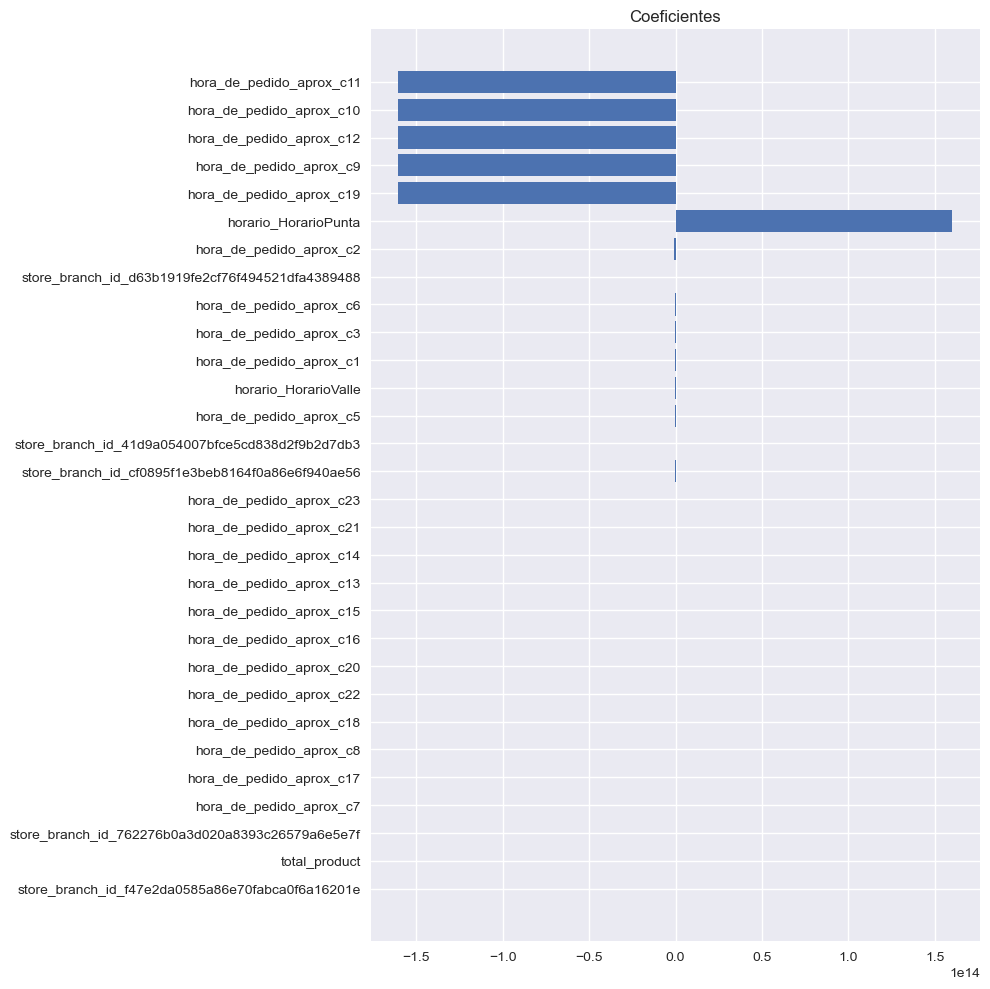

Comienza entrenamiento modelo variables relevantes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Resultados grilla modelo depurado

 The best estimator across ALL searched params:
 LinearRegression()

 The best score across ALL searched params:
 -5.491922635000521e+20

 The best parameters across ALL searched params:
 {}

 The coeficiente de determinación  de la predicción across ALL searched params:
 -3.654275360001627e+21

Resultados modelo con todas las variables...
El error cuadrático medio es 425378255826662522880.00, mientras que su raiz es 20624700139.07
El error absoluto mediano es 15.72

Resultados modelo depurado.
El error cuadrático medio es 18073419332107696443752448.00, mientras que su raiz es 4251284433216.35
El error absoluto mediano es 16.55


In [12]:
df_pred, variables_relevantes_lr = fit_or_load_model(X_train, X_test, y_train, y_test, model_lr,
                                                grid = grid_lr, fit_or_load = 'fit', con_outliers = True)

Cargando modelos guardados...


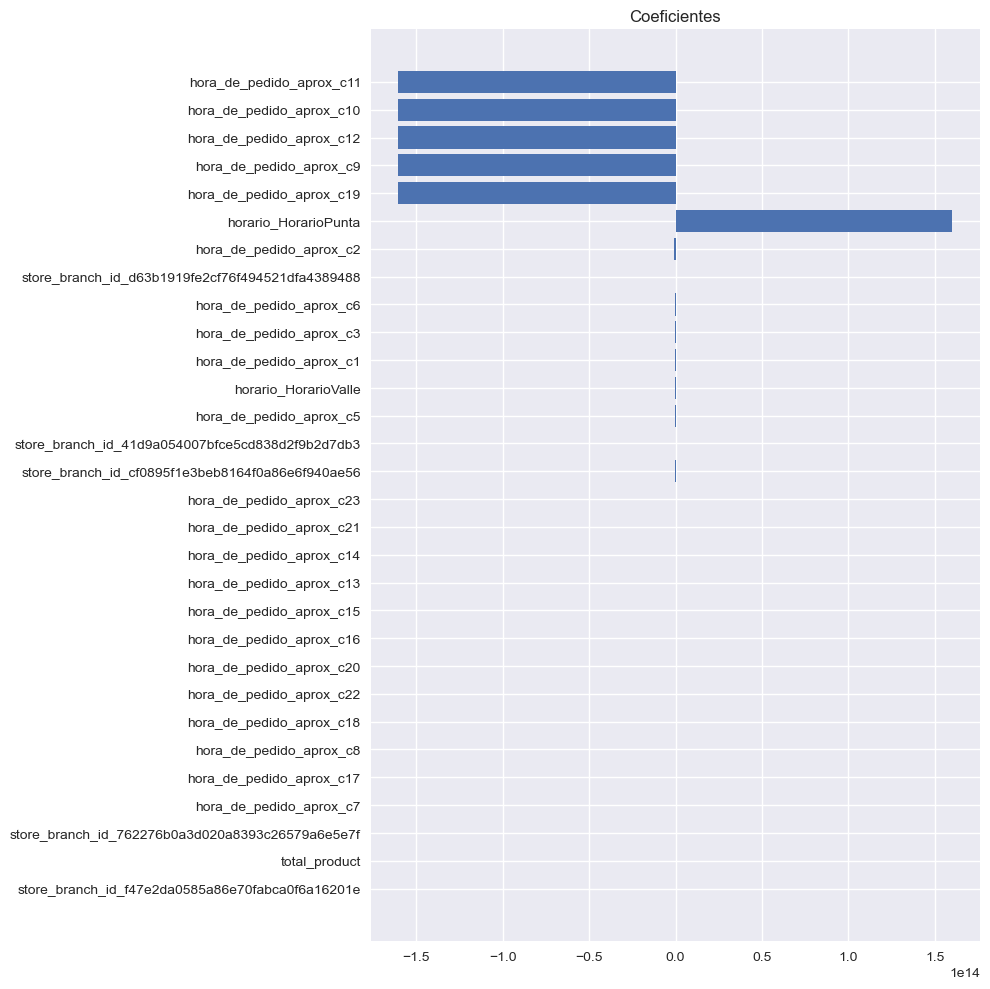


Resultados modelo con todas las variables...
El error cuadrático medio es 425378255826662522880.00, mientras que su raiz es 20624700139.07
El error absoluto mediano es 15.72

Resultados modelo depurado.
El error cuadrático medio es 18073419332107696443752448.00, mientras que su raiz es 4251284433216.35
El error absoluto mediano es 16.55


In [13]:
df_pred, variables_relevantes = fit_or_load_model(X_train, X_test, y_train, y_test, model_lr,
                                                grid = grid_lr, fit_or_load = 'load', con_outliers = True)

In [14]:
# Guardo los resultado de los modelos en un dataframe
orders_test = pd.concat([orders_test, df_pred], axis = 1)
orders_test.head()

,order_id,LinearRegression,LinearRegression_dep
0,c5fe2b7c2f032b84786701bfcc8e4fb4,105.822937,113.718750
1,d455762a86db4f47f649f5235589ca8d,80.158051,72.453125
2,d1b3af61078d65209e6d55aea6482856,72.554474,91.609375
3,170136b204ce794ef73a3b8027725b68,107.065094,101.328125
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,54.510437,66.031250


**Comentario**  
Al generar los modelos de regresión Lineal los datos nos muestran que para   :  
Modelos con todas las variables tenemos un error absoluto mediano es 15.72  
Modelo  depurado (30 mejores variables) vemos el error absoluto mediano es 16.55
Esta diferencia está marcada por la diferencia de variables si bien el la diferencia es de 0.17 no marca una mayor diferencia respecto a uno u otro modelos lo que se traduce en diferencia de minutos por ejemplo para el primer registro la diferencia es de 8 minutos.


### 2. Modelo Elastic Net

**Resumen del modelo:**

Elastic net incluye una regularización que combina la penalización l1 y l2  (αλ||β||1+12(1−α)||β||22) . El grado en que influye cada una de las penalizaciones está controlado por el hiperparámetro  α . Su valor está comprendido en el intervalo [0,1]. Cuando  α=0 , se aplica ridge y cuando  α=1  se aplica lasso. La combinación de ambas penalizaciones suele dar lugar a buenos resultados. Una estrategia frecuentemente utilizada es asignarle casi todo el peso a la penalización l1 ( α  muy próximo a 1) para conseguir seleccionar predictores y un poco a la l2 para dar cierta estabilidad en el caso de que algunos predictores estén correlacionados.

**Parámetros**:  

**l1_ratio**: por defecto es 0.5,  pero se agregó las listas  entre 0 y 1, basado en ElasticNet, donde las penalidades es una combinación de L1 y L2. Este parámetro puede ser una lista donde distintos valores son probados por validación cruzada y aquel que dé el mejor puntaje de predicción es utilizado.  

**n_alphas**: es el Número de alfas a lo largo de la ruta de regularización, usado para cada l1_ratio.


In [15]:
grid_en = {
    'l1_ratio':[.1, .5, .7, .9, .95, .99, 1],
    'n_alphas': [1, 10, 100, 500, 1000,1500,2000]
    }

model_en = ElasticNetCV(max_iter = 10000, random_state = 42)

Comienza entrenamiento modelo con todas las variables...
Fitting 5 folds for each of 49 candidates, totalling 245 fits


C:\Users\jahof\anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6115.1259625786915, tolerance: 1129.093806806387
  model = cd_fast.enet_coordinate_descent_gram(


Resultados grilla

 The best estimator across ALL searched params:
 ElasticNetCV(l1_ratio=1, max_iter=10000, n_alphas=1, random_state=42)

 The best score across ALL searched params:
 0.3847379423842224

 The best parameters across ALL searched params:
 {'l1_ratio': 1, 'n_alphas': 1}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.5999473748916765
Comienza identificación de top n variables relevantes...


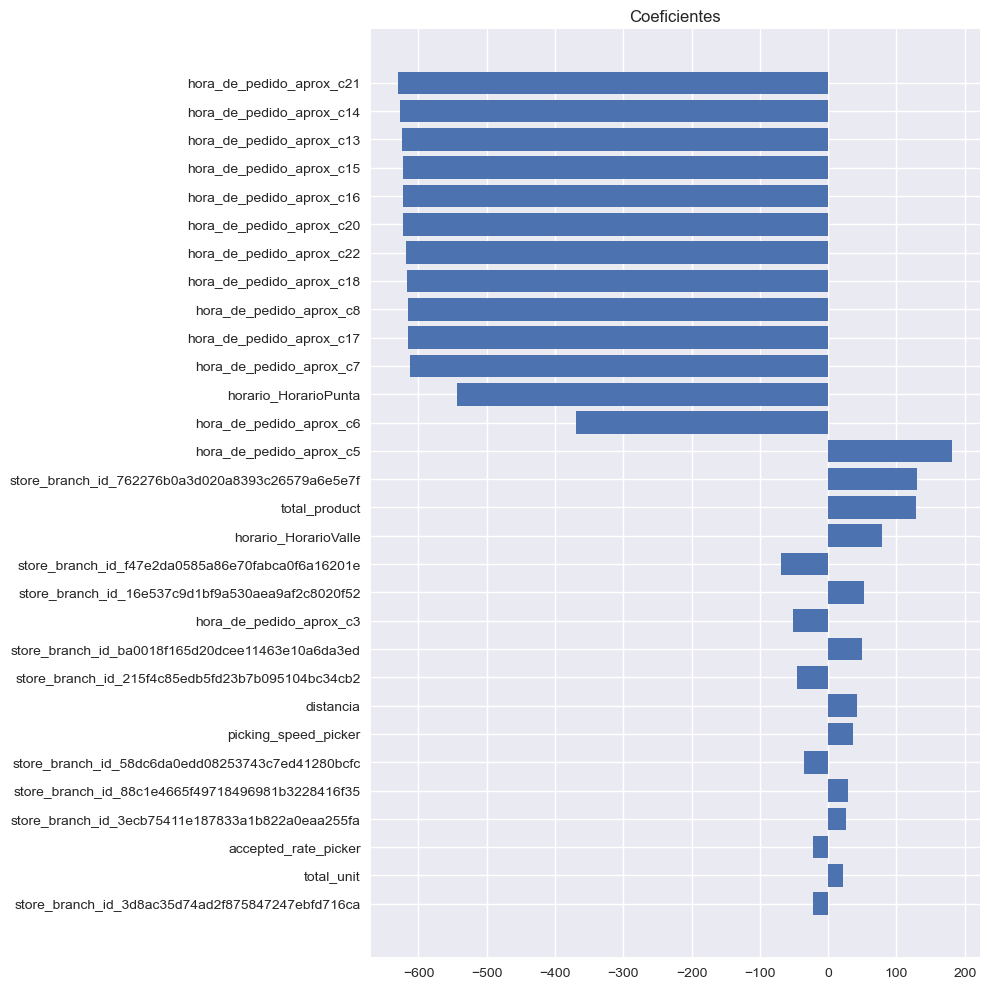

Comienza entrenamiento modelo variables relevantes...
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Resultados grilla modelo depurado

 The best estimator across ALL searched params:
 ElasticNetCV(l1_ratio=1, max_iter=10000, n_alphas=10, random_state=42)

 The best score across ALL searched params:
 0.3916755756737101

 The best parameters across ALL searched params:
 {'l1_ratio': 1, 'n_alphas': 10}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.5909977973665228

Resultados modelo con todas las variables...
El error cuadrático medio es 1978.59, mientras que su raiz es 44.48
El error absoluto mediano es 15.48

Resultados modelo depurado.
El error cuadrático medio es 2022.85, mientras que su raiz es 44.98
El error absoluto mediano es 15.03


In [16]:
df_pred, variables_relevantes_en = fit_or_load_model(X_train, X_test, y_train, y_test, model_en,
                                                grid = grid_en, fit_or_load = 'fit', con_outliers = True)

Cargando modelos guardados...


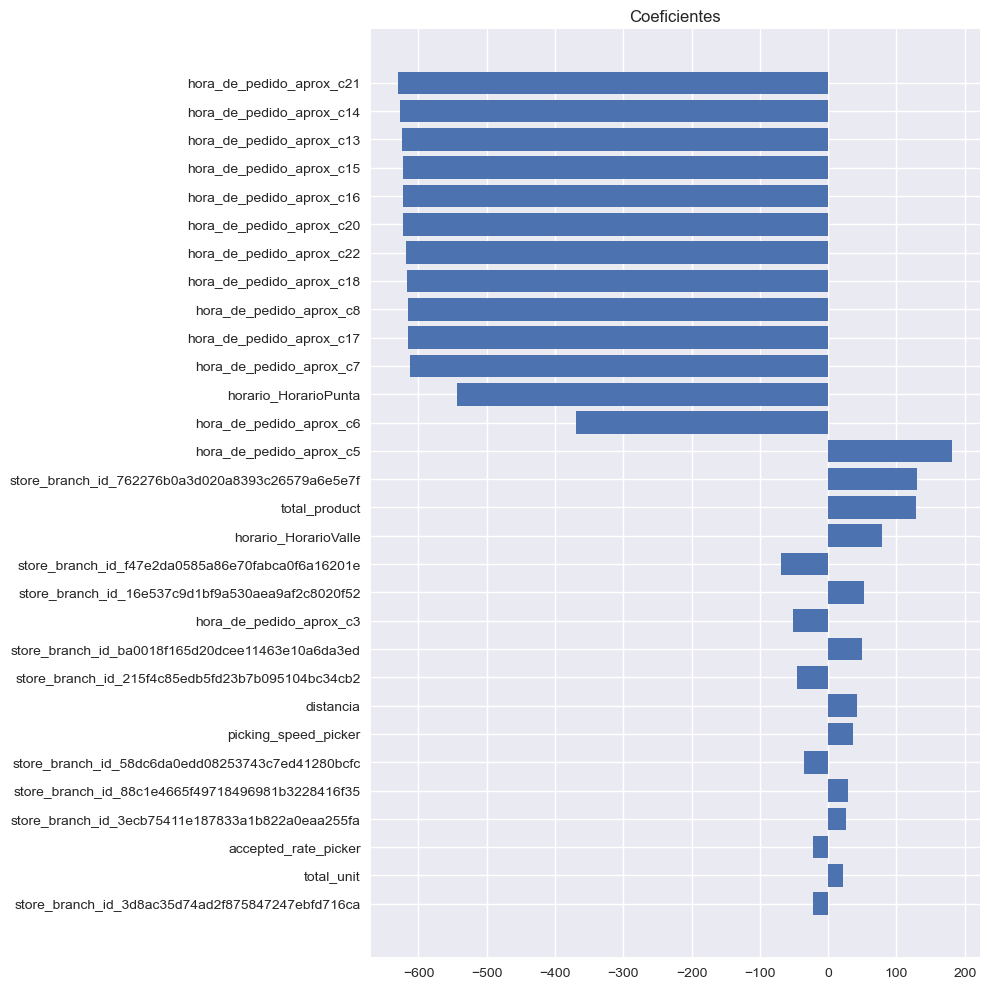


Resultados modelo con todas las variables...
El error cuadrático medio es 1978.59, mientras que su raiz es 44.48
El error absoluto mediano es 15.48

Resultados modelo depurado.
El error cuadrático medio es 2022.85, mientras que su raiz es 44.98
El error absoluto mediano es 15.03


In [17]:
df_pred, variables_relevantes_en = fit_or_load_model(X_train, X_test, y_train, y_test, model_en,
                                                grid = grid_en, fit_or_load = 'load', con_outliers = True)

In [18]:
orders_test = pd.concat([orders_test, df_pred], axis = 1)
orders_test.head()

,order_id,LinearRegression,LinearRegression_dep,ElasticNetCV,ElasticNetCV_dep
0,c5fe2b7c2f032b84786701bfcc8e4fb4,105.822937,113.718750,106.212765,110.081194
1,d455762a86db4f47f649f5235589ca8d,80.158051,72.453125,79.928913,75.921238
2,d1b3af61078d65209e6d55aea6482856,72.554474,91.609375,72.904164,86.478470
3,170136b204ce794ef73a3b8027725b68,107.065094,101.328125,107.380250,97.876717
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,54.510437,66.031250,55.762571,62.917233


**Comentario**  
Para el modelo Elastic Net igual que para el modelo anterior, tenemos un modelo full y otro depurado. El comportamiento de este modelos es mucho mejor al de regresión lineal dado que este modelos tiene penalizaciones ya que se basan en L1 y L2. de la ruta de regularización, usado para cada l1_ratio.  

Ya con el resultado de este modelo, se puede hacer una comparación directa con la regresión lineal. El primer modelo tiene un error cuadrático medio muy alto debido a que ciertas predicciones de test tienen mucho error. Además, se observa que los coeficientes resultantes son muy altos en términos absolutos. Elastic Net corrige esto penalizando los coeficientes altos, logrando una generación mejor.


### 3. SGDRegressor

La implementación SVR se basa en libsvm. La complejidad del tiempo de ajuste es más que cuadrática con el número de muestras lo cual lo hace dificil para escalar a conjuntos de datos con más de un par de 10000 muestras. Para conjuntos de datos mas grandes consideré usar LinearSVR o SGDRegressor en su lugar.

**SGDRegressor**

SGD son las siglas de Stochastic Gradient Descent: el gradiente de la pérdida se estima cada muestra a la vez y el modelo se actualiza por el camino con un programa de fuerza decreciente (también conocido como tasa de aprendizaje).

In [19]:
grid_sgd = {
    'loss': ['epsilon_insensitive'],
    'l1_ratio':[.1, .5, .7, .9, .95, .99, 1],
    'alpha': [0.0001, 0.001, 0.01,0.1]
    }

model_sgd = SGDRegressor(max_iter=1000, tol=1e-5)


Comienza entrenamiento modelo con todas las variables...
Fitting 5 folds for each of 28 candidates, totalling 140 fits


C:\Users\jahof\anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Resultados grilla

 The best estimator across ALL searched params:
 SGDRegressor(l1_ratio=1, loss='epsilon_insensitive', tol=1e-05)

 The best score across ALL searched params:
 0.10365683424023739

 The best parameters across ALL searched params:
 {'alpha': 0.0001, 'l1_ratio': 1, 'loss': 'epsilon_insensitive'}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.06947385086129698
Comienza identificación de top n variables relevantes...


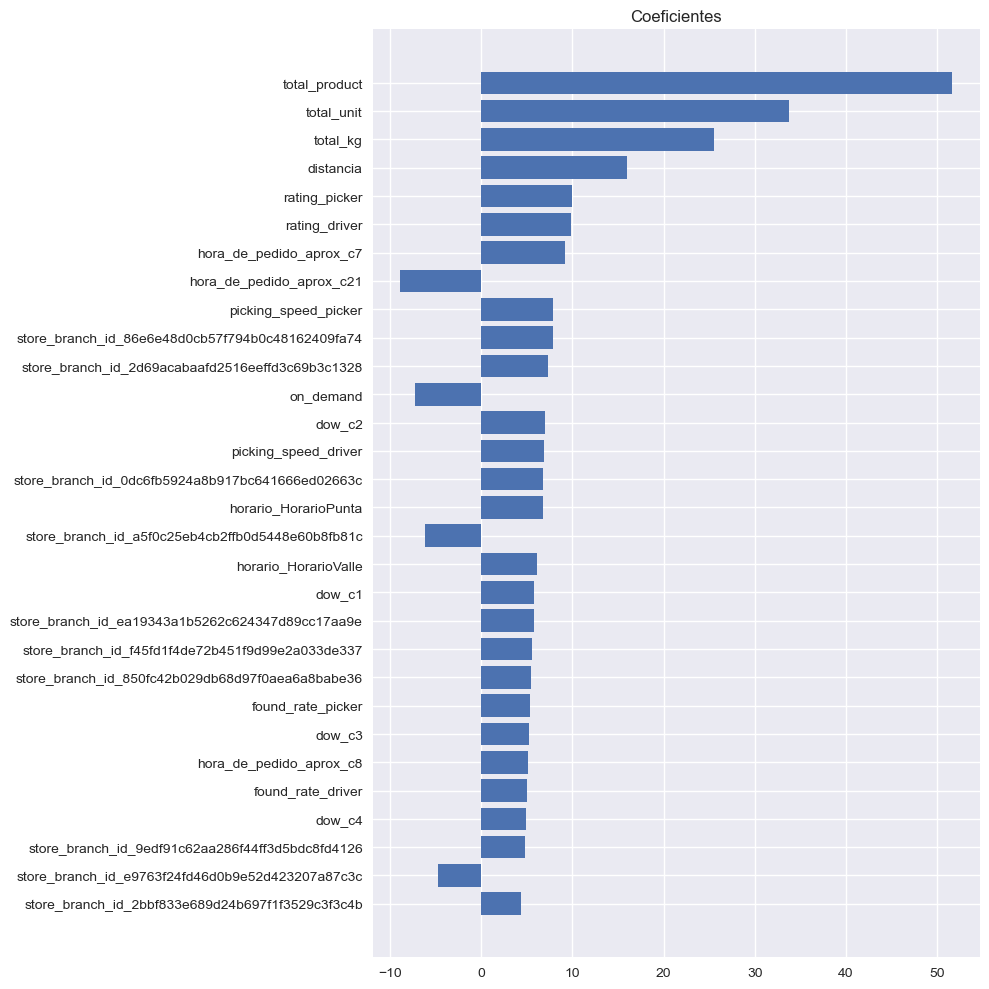

Comienza entrenamiento modelo variables relevantes...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Resultados grilla modelo depurado

 The best estimator across ALL searched params:
 SGDRegressor(l1_ratio=0.7, loss='epsilon_insensitive', tol=1e-05)

 The best score across ALL searched params:
 0.10295904217079858

 The best parameters across ALL searched params:
 {'alpha': 0.0001, 'l1_ratio': 0.7, 'loss': 'epsilon_insensitive'}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.06624693584024965

Resultados modelo con todas las variables...
El error cuadrático medio es 4602.22, mientras que su raiz es 67.84
El error absoluto mediano es 16.23

Resultados modelo depurado.
El error cuadrático medio es 4618.18, mientras que su raiz es 67.96
El error absoluto mediano es 15.89


C:\Users\jahof\anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [20]:
df_pred, variables_relevantes_sgd = fit_or_load_model(X_train, X_test, y_train, y_test, model_sgd,
                                                grid = grid_sgd, fit_or_load = 'fit', con_outliers = True)

Cargando modelos guardados...


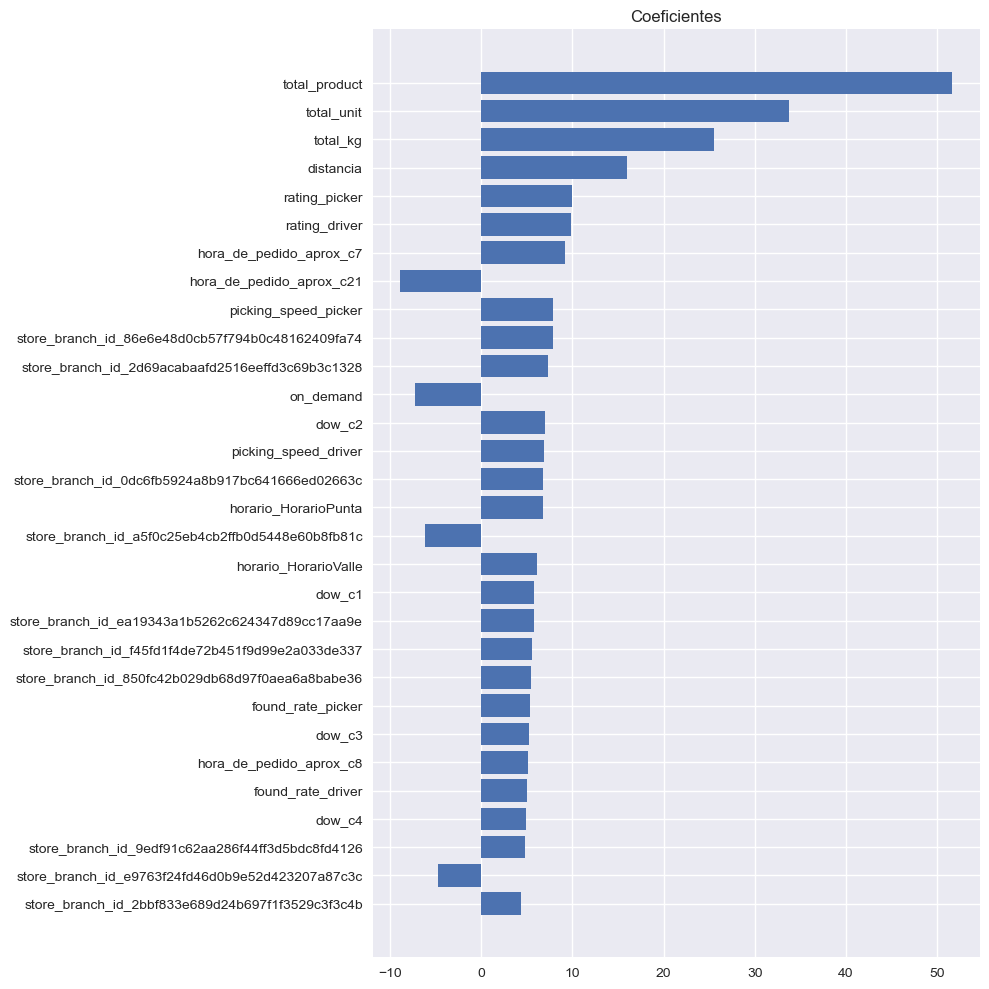


Resultados modelo con todas las variables...
El error cuadrático medio es 4602.22, mientras que su raiz es 67.84
El error absoluto mediano es 16.23

Resultados modelo depurado.
El error cuadrático medio es 4618.18, mientras que su raiz es 67.96
El error absoluto mediano es 15.89


In [21]:
df_pred, variables_relevantes_sgd = fit_or_load_model(X_train, X_test, y_train, y_test, model_sgd,
                                                grid = grid_sgd, fit_or_load = 'load', con_outliers = True)

In [22]:
orders_test = pd.concat([orders_test, df_pred], axis = 1)
orders_test.head()

,order_id,LinearRegression,LinearRegression_dep,ElasticNetCV,ElasticNetCV_dep,SGDRegressor,SGDRegressor_dep
0,c5fe2b7c2f032b84786701bfcc8e4fb4,105.822937,113.718750,106.212765,110.081194,96.428357,97.224325
1,d455762a86db4f47f649f5235589ca8d,80.158051,72.453125,79.928913,75.921238,89.438683,91.458288
2,d1b3af61078d65209e6d55aea6482856,72.554474,91.609375,72.904164,86.478470,74.455900,76.041959
3,170136b204ce794ef73a3b8027725b68,107.065094,101.328125,107.380250,97.876717,96.259829,91.220495
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,54.510437,66.031250,55.762571,62.917233,70.612608,70.735221


**Comentario**

Al igual que modelos anteriores se generan dos modelos uno Full y depurado. En este caso,  ambos modelos presentan un error bastante similar. El modelo Full tiene mayor error mediano absoluto, pero menor error cuadrático medio. En un caso como este es bastante claro que el modelo depurado es mejor dada su mayor simpleza.


### 4. GradientBoostingRegressor

Este estimador construye un modelo aditivo en una forma avanzada por etapas; permite la optimización de funciones de pérdida diferenciables arbitrarias. En cada etapa se ajusta un árbol de regresión sobre el gradiente negativo de la función de pérdida dada.

learning_ratefloat, default=0.1 La tasa de aprendizaje reduce la contribución de cada árbol por tasa_de_aprendizaje. Hay una compensación entre learning_rate y n_estimators. 

n_estimadoresint, por defecto=100 El número de etapas de refuerzo a realizar. El aumento de gradiente es bastante resistente al sobreajuste, por lo que un gran número generalmente da como resultado un mejor rendimiento. 

subsample: float, default=1.0 La fracción de muestras que se usará para ajustar a los alumnos base individuales. Si es menor que 1,0, esto da como resultado un aumento de gradiente estocástico. submuestra interactúa con el parámetro n_estimators. Elegir una submuestra < 1,0 conduce a una reducción de la varianza y a un aumento del sesgo.


In [23]:
grid_gbr = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 500, 1000, 2000],
    'subsample': [0.1,0.5,0.9, 1]
}

model_gb = GradientBoostingRegressor(random_state = 42)


Comienza entrenamiento modelo con todas las variables...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Resultados grilla

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=42,
                          subsample=0.5)

 The best score across ALL searched params:
 0.24481999410141536

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'n_estimators': 500, 'subsample': 0.5}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.2676585461794546
Comienza identificación de top n variables relevantes...


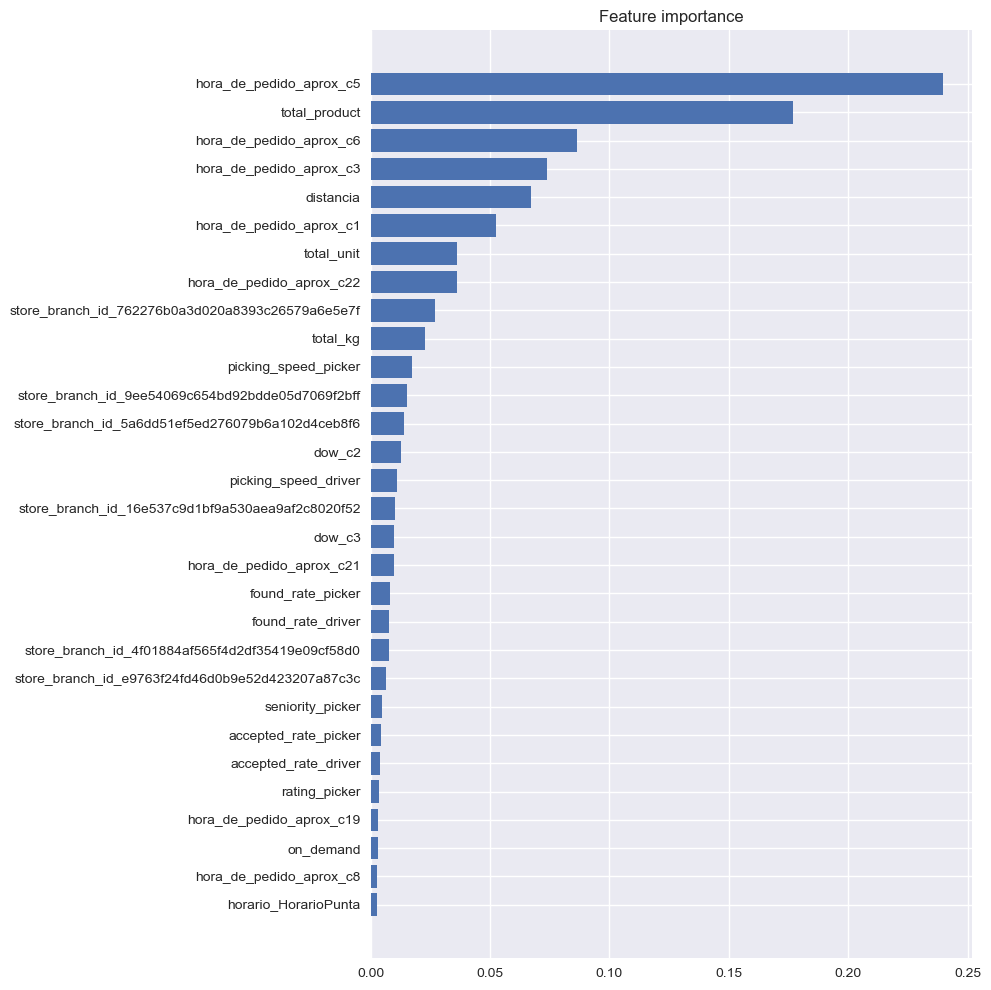

Comienza entrenamiento modelo variables relevantes...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Resultados grilla modelo depurado

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=42,
                          subsample=0.5)

 The best score across ALL searched params:
 0.24567988384139774

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'n_estimators': 500, 'subsample': 0.5}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.26956126869802577

Resultados modelo con todas las variables...
El error cuadrático medio es 3622.04, mientras que su raiz es 60.18
El error absoluto mediano es 15.71

Resultados modelo depurado.
El error cuadrático medio es 3612.62, mientras que su raiz es 60.11
El error absoluto mediano es 15.75


In [24]:
df_pred, variables_relevantes_gb = fit_or_load_model(X_train, X_test, y_train, y_test, model_gb,
                                                grid = grid_gbr, fit_or_load = 'fit', con_outliers = True)

Cargando modelos guardados...


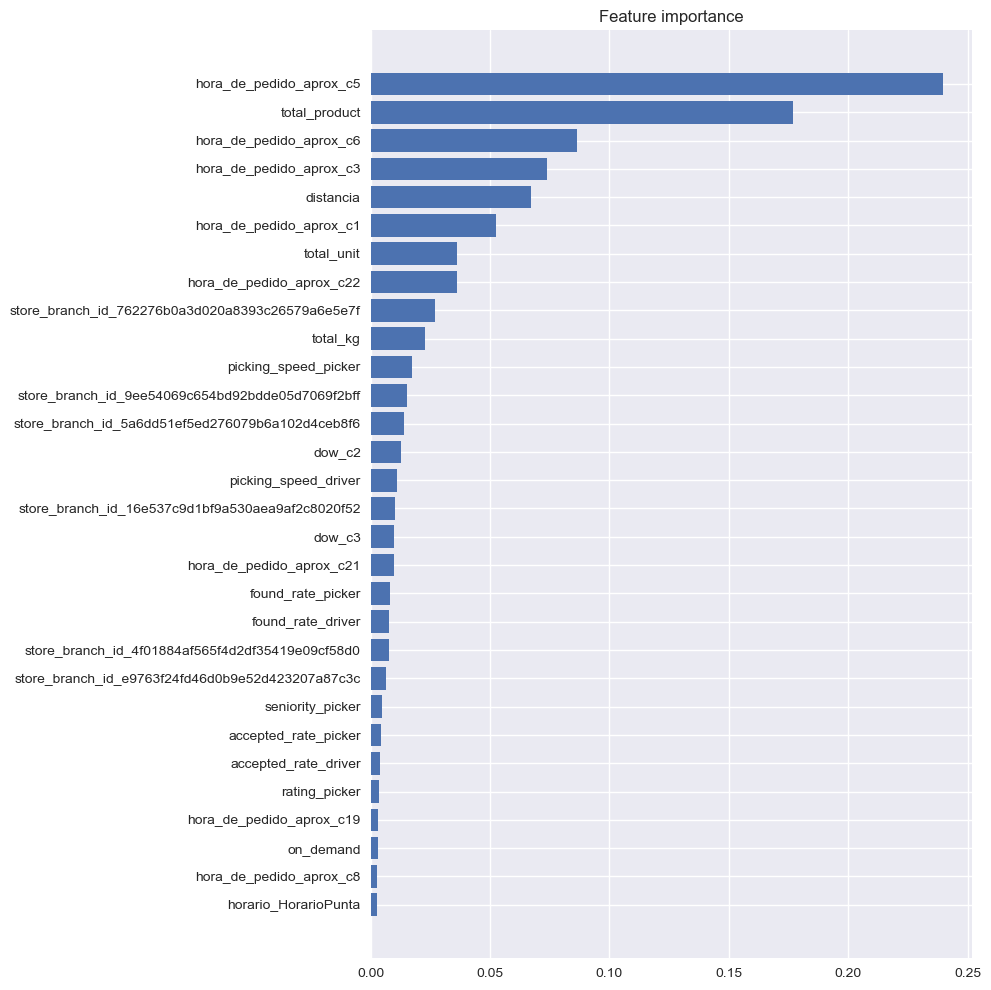


Resultados modelo con todas las variables...
El error cuadrático medio es 3622.04, mientras que su raiz es 60.18
El error absoluto mediano es 15.71

Resultados modelo depurado.
El error cuadrático medio es 3612.62, mientras que su raiz es 60.11
El error absoluto mediano es 15.75


In [25]:
df_pred, variables_relevantes_gb = fit_or_load_model(X_train, X_test, y_train, y_test, model_gb,
                                                grid = grid_gbr, fit_or_load = 'load', con_outliers = True)

In [26]:
orders_test = pd.concat([orders_test, df_pred], axis = 1)
orders_test.head()

,order_id,LinearRegression,LinearRegression_dep,ElasticNetCV,ElasticNetCV_dep,SGDRegressor,SGDRegressor_dep,GradientBoostingRegressor,GradientBoostingRegressor_dep
0,c5fe2b7c2f032b84786701bfcc8e4fb4,105.822937,113.718750,106.212765,110.081194,96.428357,97.224325,106.668290,107.008489
1,d455762a86db4f47f649f5235589ca8d,80.158051,72.453125,79.928913,75.921238,89.438683,91.458288,83.001867,79.900550
2,d1b3af61078d65209e6d55aea6482856,72.554474,91.609375,72.904164,86.478470,74.455900,76.041959,92.094175,92.337704
3,170136b204ce794ef73a3b8027725b68,107.065094,101.328125,107.380250,97.876717,96.259829,91.220495,96.953439,96.388794
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,54.510437,66.031250,55.762571,62.917233,70.612608,70.735221,64.201023,64.532459


**Comentario**  

Para Gradient Boosting tanto el modelo completo como el depurado tienen rendimientos similares. Esto nos indica que sería bueno entrenar un modelo con menor cantidad de atributos, pero permitirle iterar más tiempo. Cabe destacar que si bien tiene un error absoluto mediano similar a Elastic Net, este último es considerablemente mejor en Error cuadrático medio. Lo anterior nos indica que Gradient boost tiene un buen rendimiento mediano, sin embargo, tiene outliers en su distribución del error.

### RandomForestRegressor

Un bosque aleatorio es un metaestimador que ajusta una serie de árboles de decisión de clasificación en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y controlar el sobreajuste. El tamaño de la submuestra se controla con el parámetro max_samples si bootstrap=True (predeterminado); de lo contrario, se usa todo el conjunto de datos para construir cada árbol.



In [27]:
grid_rf = {"n_estimators": [10, 50, 100],
           "criterion": ['squared_error'],
           "max_depth":  np.linspace(2,32, dtype=int, num=4) , # genero el maximo de profundidad entre 1 y 32
           "max_features": list(range(7, X_train.shape[1]+1)) #genero maximo atributos, genero un rango pero lo envuelvo en una lista desde 1 a la cantidad de columnas
           }

model_rf = RandomForestRegressor(random_state = 42)



Comienza entrenamiento modelo con todas las variables...
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Resultados grilla

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=12, max_features=83, random_state=42)

 The best score across ALL searched params:
 0.2386371894989122

 The best parameters across ALL searched params:
 {'criterion': 'squared_error', 'max_depth': 12, 'max_features': 83, 'n_estimators': 100}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.24643571572118794
Comienza identificación de top n variables relevantes...


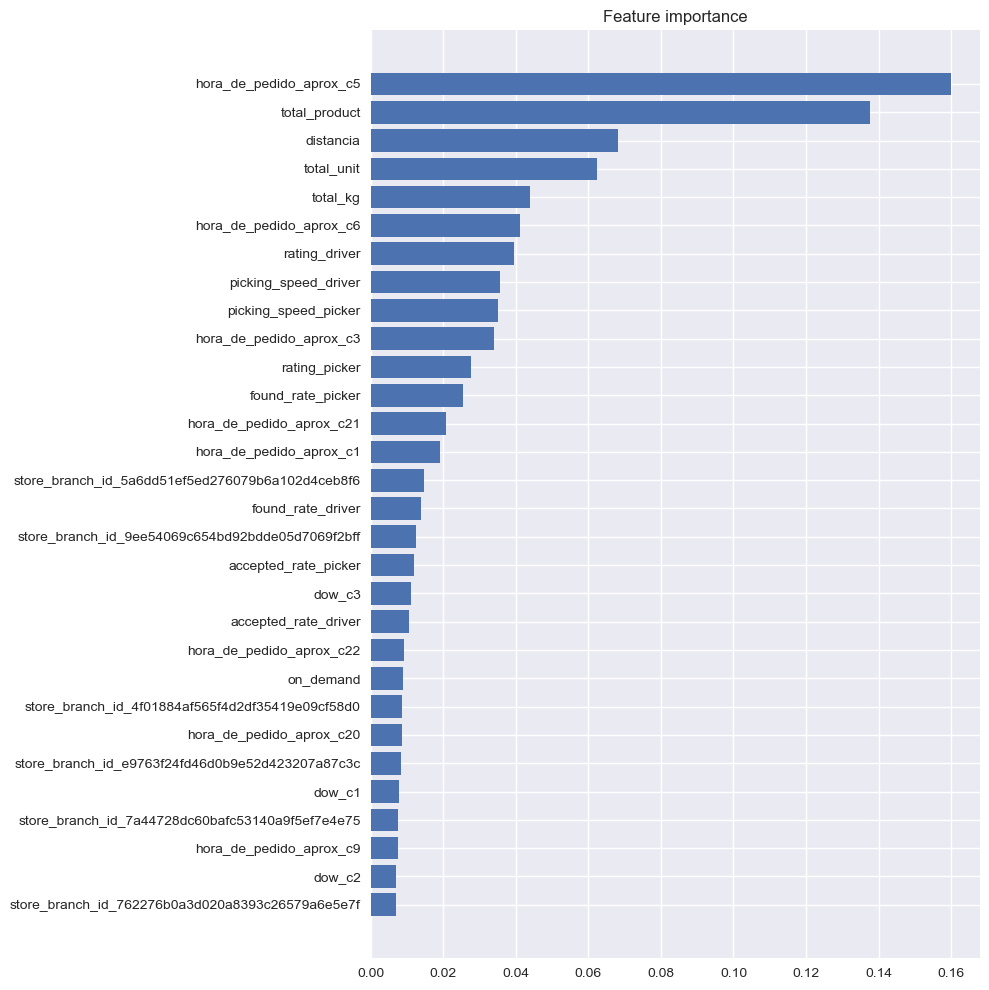

Comienza entrenamiento modelo variables relevantes...
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Resultados grilla modelo depurado

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=12, max_features=16, random_state=42)

 The best score across ALL searched params:
 0.2255422610668473

 The best parameters across ALL searched params:
 {'criterion': 'squared_error', 'max_depth': 12, 'max_features': 16, 'n_estimators': 100}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.23610885422809302

Resultados modelo con todas las variables...
El error cuadrático medio es 3727.00, mientras que su raiz es 61.05
El error absoluto mediano es 15.26

Resultados modelo depurado.
El error cuadrático medio es 3778.07, mientras que su raiz es 61.47
El error absoluto mediano es 15.27


In [28]:
df_pred, variables_relevantes_rf = fit_or_load_model(X_train, X_test, y_train, y_test, model_rf,
                                                grid = grid_rf, fit_or_load = 'fit', con_outliers = True)

Cargando modelos guardados...


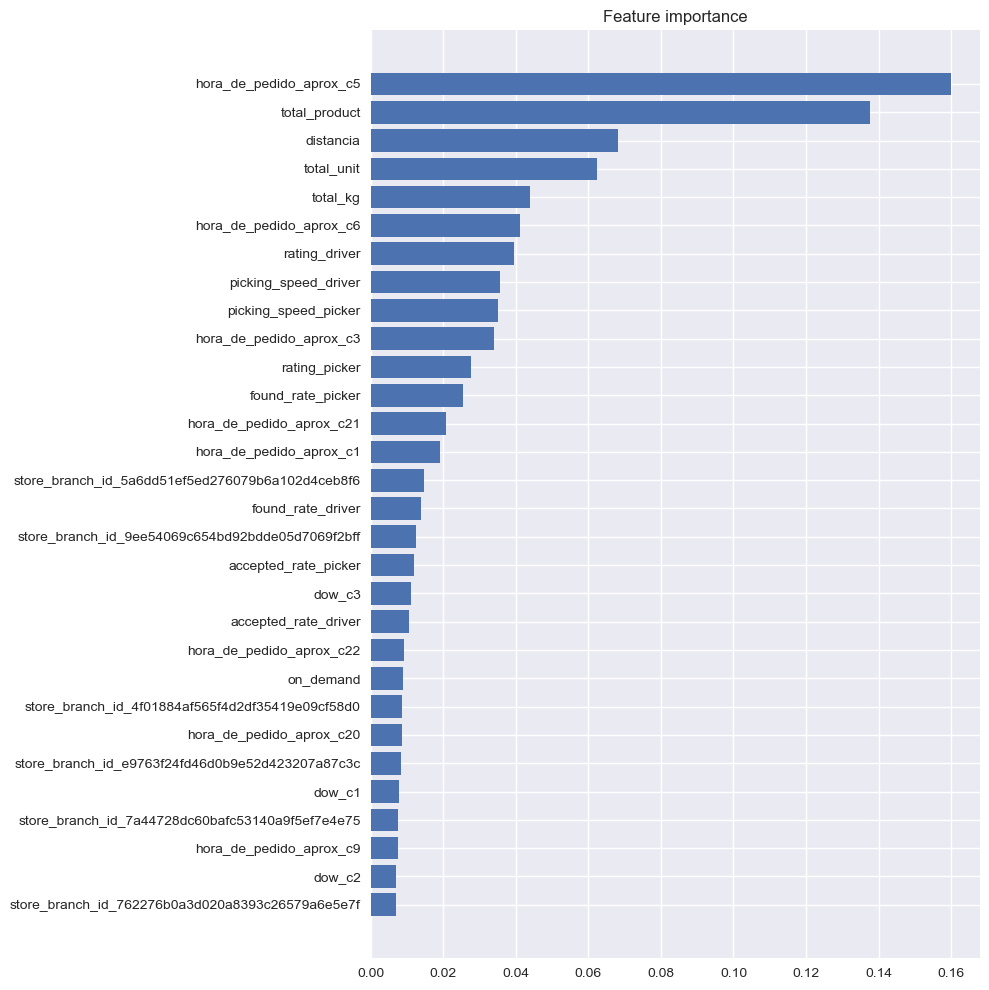


Resultados modelo con todas las variables...
El error cuadrático medio es 3727.00, mientras que su raiz es 61.05
El error absoluto mediano es 15.26

Resultados modelo depurado.
El error cuadrático medio es 3778.07, mientras que su raiz es 61.47
El error absoluto mediano es 15.27


In [29]:
df_pred, variables_relevantes_rf = fit_or_load_model(X_train, X_test, y_train, y_test, model_rf,
                                                grid = grid_rf, fit_or_load = 'load', con_outliers = True)

In [30]:
orders_test = pd.concat([orders_test, df_pred], axis = 1)
orders_test.head()

,order_id,LinearRegression,LinearRegression_dep,ElasticNetCV,ElasticNetCV_dep,SGDRegressor,SGDRegressor_dep,GradientBoostingRegressor,GradientBoostingRegressor_dep,RandomForestRegressor,RandomForestRegressor_dep
0,c5fe2b7c2f032b84786701bfcc8e4fb4,105.822937,113.718750,106.212765,110.081194,96.428357,97.224325,106.668290,107.008489,104.261475,112.753529
1,d455762a86db4f47f649f5235589ca8d,80.158051,72.453125,79.928913,75.921238,89.438683,91.458288,83.001867,79.900550,75.686496,85.285152
2,d1b3af61078d65209e6d55aea6482856,72.554474,91.609375,72.904164,86.478470,74.455900,76.041959,92.094175,92.337704,80.523963,88.839374
3,170136b204ce794ef73a3b8027725b68,107.065094,101.328125,107.380250,97.876717,96.259829,91.220495,96.953439,96.388794,94.992017,92.247694
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,54.510437,66.031250,55.762571,62.917233,70.612608,70.735221,64.201023,64.532459,62.952922,63.922482


**Comentarios**  

Nuevamente, obtenemos resultados prácticamente iguales en el modelo full y en el modelo depurado. Lo anterior nos indica que las columnas que se extraen de la muestra no son de tanta relevancia.

## Analizando resultados
Construidos los 10 modelos, se procede a analizar los resultados a nivel agrupado.

In [31]:
# genero lista de modelos
lista_modelos = list(orders_test.columns)
lista_modelos.remove('order_id')
lista_modelos = ['modelo_campeon'] + lista_modelos 
lista_modelos

['modelo_campeon',
 'LinearRegression',
 'LinearRegression_dep',
 'ElasticNetCV',
 'ElasticNetCV_dep',
 'SGDRegressor',
 'SGDRegressor_dep',
 'GradientBoostingRegressor',
 'GradientBoostingRegressor_dep',
 'RandomForestRegressor',
 'RandomForestRegressor_dep']

In [32]:
# Se hace merge entre el df original y el df con predicciones
df_result = pd.merge(df, orders_test, how='inner', left_on = 'order_id', right_on = 'order_id', suffixes = ('_order', '_store'))
with pd.option_context("display.max_columns", None):
    display(df_result.head(n = 5))
 

,order_id,lat_order,lng_order,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes,actual_reception_time,promised_delivery_time,total_minutes_td,order_time,model_1_dt_time,model_1_time,store,lat_store,lng_store,shopper_id_picker,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,shopper_id_driver,seniority_driver,found_rate_driver,picking_speed_driver,accepted_rate_driver,rating_driver,total_product,real_total_unit,real_total_kg,real_without_product,total_unit,total_kg,distancia,hora_de_pedido_aprox,horario,LinearRegression,LinearRegression_dep,ElasticNetCV,ElasticNetCV_dep,SGDRegressor,SGDRegressor_dep,GradientBoostingRegressor,GradientBoostingRegressor_dep,RandomForestRegressor,RandomForestRegressor_dep
0,0d37a1eea001f01b40232ffd496ff663,18.17771,-10.03570,2,13:00:00,10:28:10,False,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599732,1900-01-01 10:28:10,1900-01-01 13:00:00,0 days 03:26:35.983919999,1900-01-01 07:01:34.016080001,0 days 05:58:25.983919999,358.433065,387d4a5b65cf4bf00ad805c4b00eed01,18.16396,-10.03289,c4c722114a82fa21654e57e9636d68b0,ADVANCED,0.85,1.14,1.00,4.76,c4c722114a82fa21654e57e9636d68b0,ADVANCED,0.85,1.14,1.00,4.76,103.0,114.0,40.614,20.0,150.0,39.562,1.557488,7,HorarioValle,223.745392,207.328125,223.193025,210.091991,179.524323,183.287520,177.755674,174.696917,212.054122,212.147872
1,e0ad6533b6cd9a382ec6c1d473c5036c,18.22911,-10.03226,2,11:00:00,10:07:53,False,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321208,1900-01-01 10:07:53,1900-01-01 11:00:00,0 days 02:10:19.272480,1900-01-01 07:57:33.727520000,0 days 03:02:26.272480,182.437875,452ae015bf846e1d2932b7ea15720d64,18.23159,-10.03145,06a71e8ab0c6db5ce22a4689fd76a3f4,ADVANCED,0.86,1.89,1.00,4.92,06a71e8ab0c6db5ce22a4689fd76a3f4,ADVANCED,0.86,1.89,1.00,4.92,44.0,28.0,11.575,3.0,31.0,7.721,0.288728,7,HorarioValle,115.487457,126.953125,115.545199,122.178763,112.162676,111.765198,112.307059,112.409124,125.860811,122.175117
2,073eca5efe7ebb1073ec80cb90185c20,18.22078,-10.04173,2,12:00:00,11:00:15,False,e0322b49c16e71de1fe1837d98f23468,e0322b49c16e71de1fe1837d98f23468,3dd9ae393aa5327edfb27388758436bd,65.901589,1900-01-01 11:00:15,1900-01-01 12:00:00,0 days 01:05:54.095340,1900-01-01 09:54:20.904660000,0 days 02:05:39.095340,125.651589,0fae7b61265bc7ca4ce4d81440b62501,18.26223,-10.04150,e0322b49c16e71de1fe1837d98f23468,ADVANCED,0.89,1.58,1.00,5.00,e0322b49c16e71de1fe1837d98f23468,ADVANCED,0.89,1.58,1.00,5.00,2.0,2.0,0.000,0.0,2.0,0.000,4.609100,9,HorarioPunta,65.729187,65.609375,65.683180,63.856215,73.039943,77.634964,67.845160,67.555470,68.282905,70.368612
3,c1800bdd3c666b497b39d6e526917167,18.22094,-10.04172,2,10:00:00,8:46:04,False,a083ea904c55052cdb58917ed790ca96,a083ea904c55052cdb58917ed790ca96,2d69acabaafd2516eeffd3c69b3c1328,665.212000,1900-01-01 08:46:04,1900-01-01 10:00:00,0 days 11:05:12.720000,1899-12-31 21:40:51.280000000,0 days 12:19:08.720000,739.145333,60e4c4e1c1a8bc79123738227b9d0b08,18.21834,-10.04157,a083ea904c55052cdb58917ed790ca96,ADVANCED,0.86,1.50,0.96,4.72,a083ea904c55052cdb58917ed790ca96,ADVANCED,0.86,1.50,0.96,4.72,20.0,22.0,0.505,2.0,25.0,0.500,0.289541,21,HorarioValle,67.958557,73.515625,67.637485,65.883234,78.619111,80.133310,78.726928,78.375835,81.154289,78.763966
4,b4c64ceaa31265a4b2ff0dec82b9beeb,18.21779,-10.03446,2,17:00:00,16:33:37,False,2bfd559c4bef0e59fee43bf322e3ea5e,2bfd559c4bef0e59fee43bf322e3ea5e,f45fd1f4de72b451f9d99e2a033de337,83.232147,1900-01-01 16:33:37,1900-01-01 17:00:00,0 days 01:23:13.928820,1900-01-01 15:10:23.071180000,0 days 01:49:36.928820,109.615480,387d4a5b65cf4bf00ad805c4b00eed01,18.22698,-10.03056,2bfd559c4bef0e59fee43bf322e3ea5e,ADVANCED,0.86,1.55,0.92,4.96,2bfd559c4bef0e59fee43bf322e3ea5e,ADVANCED,0.86,1.55,0.92,4.96,1.0,3.0,0.000,0.0,3.0,0.000,1.101779,15,HorarioValle,52.259613,56.312500,51.878501,50.598022,75

In [33]:
# se borran las columnas que son innecesarias     
columnas_drop = ['order_id', 'lat_order', 'lng_order', 
        'on_demand', 'picker_id', 'driver_id', 'store_branch_id',
       'actual_reception_time', 'promised_delivery_time',
       'total_minutes_td', 'order_time', 'model_1_dt_time',
       'store', 'lat_store', 'lng_store', 'shopper_id_picker',
       'seniority_picker', 'found_rate_picker', 'picking_speed_picker',
       'accepted_rate_picker', 'rating_picker', 'shopper_id_driver',
       'seniority_driver', 'found_rate_driver', 'picking_speed_driver',
       'accepted_rate_driver', 'rating_driver', 'total_product',
       'real_total_unit', 'real_total_kg', 'real_without_product',
       'total_unit', 'total_kg', 'distancia']

df_analisis = df_result.copy().drop(columns = columnas_drop)
df_analisis = df_analisis.rename(columns={'model_1_time': 'modelo_campeon'})
df_analisis.head()

,dow,promised_time,actual_time,total_minutes,modelo_campeon,hora_de_pedido_aprox,horario,LinearRegression,LinearRegression_dep,ElasticNetCV,ElasticNetCV_dep,SGDRegressor,SGDRegressor_dep,GradientBoostingRegressor,GradientBoostingRegressor_dep,RandomForestRegressor,RandomForestRegressor_dep
0,2,13:00:00,10:28:10,206.599732,358.433065,7,HorarioValle,223.745392,207.328125,223.193025,210.091991,179.524323,183.287520,177.755674,174.696917,212.054122,212.147872
1,2,11:00:00,10:07:53,130.321208,182.437875,7,HorarioValle,115.487457,126.953125,115.545199,122.178763,112.162676,111.765198,112.307059,112.409124,125.860811,122.175117
2,2,12:00:00,11:00:15,65.901589,125.651589,9,HorarioPunta,65.729187,65.609375,65.683180,63.856215,73.039943,77.634964,67.845160,67.555470,68.282905,70.368612
3,2,10:00:00,8:46:04,665.212000,739.145333,21,HorarioValle,67.958557,73.515625,67.637485,65.883234,78.619111,80.133310,78.726928,78.375835,81.154289,78.763966
4,2,17:00:00,16:33:37,83.232147,109.615480,15,HorarioValle,52.259613,56.312500,51.878501,50.598022,75.668304,77.004969,60.770108,60.684438,58.570933,59.551662


In [34]:
# Genero el reporte
report_hra = pd.concat([
    calcular_error_modelo(df_analisis, model_i, 'horario') for model_i in lista_modelos
],
axis = 0)
report_hra.astype(float).to_csv('report_hra.csv', sep = ';', decimal = ',')

report_hra.drop(index = ['LinearRegression_ErrorCuadraticoMedio', 'LinearRegression_dep_ErrorCuadraticoMedio'])


horario,HorarioNocturno,HorarioPunta,HorarioValle
modelo_campeon_ErrorMedianoAbsoluto,41.283333,37.4,32.85
modelo_campeon_ErrorCuadraticoMedio,2192.27966,2119.383382,1877.240227
LinearRegression_ErrorMedianoAbsoluto,434.234437,14.091905,16.249958
LinearRegression_dep_ErrorMedianoAbsoluto,414.496125,14.814378,17.383453
ElasticNetCV_ErrorMedianoAbsoluto,97.691625,13.882672,16.005452
ElasticNetCV_ErrorCuadraticoMedio,73979.745838,1404.557127,1813.780554
ElasticNetCV_dep_ErrorMedianoAbsoluto,101.463024,13.857738,15.796893
ElasticNetCV_dep_ErrorCuadraticoMedio,74028.35877,1471.521665,1841.948103
SGDRegressor_ErrorMedianoAbsoluto,648.766878,15.378058,16.799673
SGDRegressor_ErrorCuadraticoMedio,452008.372365,1477.35642,3265.317347


**Comentarios**  
A partir de la tabla anterior, así como del archivo .csv construido, se puede concluir lo siguiente:
- **Horario nocturno**: Para el error mediano absoluto el modelo campeón tiene una estimación con un error que es fácilmente 10 veces menor. De hecho, la mitad de los pedidos nocturnos tiene un error menor a 41 minutos. En cambio, el mejor modelo desafiante tiene un error de 98 minutos en su versión full y 101 minutos en su versión depurada. Con el error cuadrático la situación es excatamente igual.
- **Horario punta**:  Mientras el modelo campeón tiene un error absoluto mediano de 37.4 minutos, los mejores modelos desafiantes tienen errores bajo los 14 minutos incluso. Eso quiere decir que la mitad de los pedidos se predice con menos de 14 minutos de error. Nuevamente, en el error cuadrático medio se presenta el mismo comportamiento. 
- **Horario valle**: La situación es la misma que en el horario punta, existe una notable mejora respecto al modelo campeón.

En resumen, se observa que el modelo campeón tiene un excelente rendimiento en el horario nocturno. Sin embargo, cabe preguntarse si ese es realmente el objetivo. ¿Cuánto sumamos por predecir bien pedidos que se hacen durante la noche? la intuición dice que poco. En cambio, la mejora de 23 minutos que se produce en el horario punta es de alto impacto.

In [35]:
report_dow = pd.concat([
    calcular_error_modelo(df_analisis, model_i, 'dow') for model_i in lista_modelos
],
axis = 0)
report_dow.astype(float).to_csv('report_dow.csv', sep = ';', decimal = ',')

report_dow.drop(index = ['LinearRegression_ErrorCuadraticoMedio', 'LinearRegression_dep_ErrorCuadraticoMedio'])


dow,0.0,1.0,2.0,3.0,4.0,5.0,6.0
modelo_campeon_ErrorMedianoAbsoluto,29.783333,35.983333,34.066667,39.300000,36.100000,34.100000,35.608333
modelo_campeon_ErrorCuadraticoMedio,1757.852079,1794.375676,2078.586612,2493.703660,1866.067949,1809.474836,1707.977526
LinearRegression_ErrorMedianoAbsoluto,18.791858,13.886583,15.204275,15.801431,16.757593,14.753409,12.595955
LinearRegression_dep_ErrorMedianoAbsoluto,19.297615,16.549343,15.999952,16.723849,17.977111,12.950238,13.353726
ElasticNetCV_ErrorMedianoAbsoluto,18.344368,13.896759,15.109603,15.257957,16.704609,13.929502,12.275556
ElasticNetCV_ErrorCuadraticoMedio,1129.398426,2855.414221,3082.269556,1122.805540,2273.066297,983.439755,745.492626
ElasticNetCV_dep_ErrorMedianoAbsoluto,18.218389,14.733327,14.911076,14.996846,16.436705,13.380376,12.552266
ElasticNetCV_dep_ErrorCuadraticoMedio,1152.005153,2943.423504,3128.929980,1140.818716,2343.820716,1017.141719,742.760873
SGDRegressor_ErrorMedianoAbsoluto,18.357122,15.783854,16.227007,17.064979,17.370813,14.269495,14.034398
SGDRegressor_ErrorCuadraticoMedio,4045.157869,4189.193396,5111.585911,6985.012604,5187.539025,2606.794061,721.813605


**Comentarios**:
Nuevamente, dado lo visto en el reporte, además de un análisis independiente a partir del .csv, se observan varias cosas.
- Para cada día de la semana el modelo campeón es mejorado por los modelos desafiantes.
De forma consistente, Elastic net tiene un error absoluto mediano bastante bueno todos los días.
- En particular, para viernes y sábado Gradient boost tiene un gran rendimiento, llgando incluso a 11.3 minutos de error absoluto mediano.


## Entrenamiento modelos sin outliers
Esta sección es totalmente homóloga a la anterior. La gran diferencia es que en vez de utilizar el 100% de los datos, se utiliza el 95%. Aquí, lo que hacemos es quitar el 2.5% de datos menor y superior en cuanto a tiempo. Así, nos deshacemos de outliers.

En general, veremos modelos con errores menores, sobre todo en error cuadrático medio. Esto porque, como se comentaba anteriormente, ese es un error que castiga más los errores más altos.

In [36]:
df_modelo2 = df_modelo.copy()
df_modelo2.head()

,order_id,on_demand,total_minutes,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,seniority_driver,found_rate_driver,...,hora_de_pedido_aprox_c22,hora_de_pedido_aprox_c23,hora_de_pedido_aprox_c3,hora_de_pedido_aprox_c5,hora_de_pedido_aprox_c6,hora_de_pedido_aprox_c7,hora_de_pedido_aprox_c8,hora_de_pedido_aprox_c9,horario_HorarioPunta,horario_HorarioValle
0,6abd5e28d01b7c733fe37485294235dc,False,91.800861,3,0.86,1.56,1.00,4.68,3,0.86,...,0,0,0,0,0,0,0,0,1,0
1,0d37a1eea001f01b40232ffd496ff663,False,206.599732,3,0.85,1.14,1.00,4.76,3,0.85,...,0,0,0,0,0,1,0,0,0,1
2,528428e9b9eb5d3bd0dbdd8da692b087,False,93.458001,2,0.83,2.03,1.00,4.96,2,0.83,...,0,0,0,0,0,0,0,1,1,0
3,d3f7be6d64eae7405b7bf024e04807a2,False,124.778761,2,0.86,2.06,0.92,4.92,2,0.86,...,0,0,0,0,0,1,0,0,0,1
4,e0ad6533b6cd9a382ec6c1d473c5036c,False,130.321208,3,0.86,1.89,1.00,4.92,3,0.86,...,0,0,0,0,0,1,0,0,0,1


In [37]:
# Conservamos el 95% de los datos
percentil975 = np.percentile(df_modelo['total_minutes'], q = 97.5)
percentil025 =  np.percentile(df_modelo['total_minutes'], q = 2.5)

df_modelo2 = df_modelo2[(df_modelo2['total_minutes'] <= percentil975) & (df_modelo2['total_minutes'] >= percentil025)]
df_modelo2.head()

,order_id,on_demand,total_minutes,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,seniority_driver,found_rate_driver,...,hora_de_pedido_aprox_c22,hora_de_pedido_aprox_c23,hora_de_pedido_aprox_c3,hora_de_pedido_aprox_c5,hora_de_pedido_aprox_c6,hora_de_pedido_aprox_c7,hora_de_pedido_aprox_c8,hora_de_pedido_aprox_c9,horario_HorarioPunta,horario_HorarioValle
0,6abd5e28d01b7c733fe37485294235dc,False,91.800861,3,0.86,1.56,1.00,4.68,3,0.86,...,0,0,0,0,0,0,0,0,1,0
2,528428e9b9eb5d3bd0dbdd8da692b087,False,93.458001,2,0.83,2.03,1.00,4.96,2,0.83,...,0,0,0,0,0,0,0,1,1,0
3,d3f7be6d64eae7405b7bf024e04807a2,False,124.778761,2,0.86,2.06,0.92,4.92,2,0.86,...,0,0,0,0,0,1,0,0,0,1
4,e0ad6533b6cd9a382ec6c1d473c5036c,False,130.321208,3,0.86,1.89,1.00,4.92,3,0.86,...,0,0,0,0,0,1,0,0,0,1
5,f169a660e8667798da11775767cdce78,False,74.993118,2,0.85,2.33,0.96,4.64,2,0.85,...,0,0,0,0,0,0,0,0,1,0


In [38]:
X2 = df_modelo2.copy()
y2 = X2.pop('total_minutes')

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 0)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((4313, 157), (1849, 157), (4313,), (1849,))

In [39]:
X_train2 = X_train2.drop(columns = ['order_id'])
X_train2.head()

,on_demand,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,seniority_driver,found_rate_driver,picking_speed_driver,accepted_rate_driver,...,hora_de_pedido_aprox_c22,hora_de_pedido_aprox_c23,hora_de_pedido_aprox_c3,hora_de_pedido_aprox_c5,hora_de_pedido_aprox_c6,hora_de_pedido_aprox_c7,hora_de_pedido_aprox_c8,hora_de_pedido_aprox_c9,horario_HorarioPunta,horario_HorarioValle
171,True,3,0.91,1.69,0.96,4.92,3,0.91,1.69,0.96,...,0,0,0,0,0,0,1,0,0,1
3371,False,3,0.85,1.56,0.92,4.92,3,0.85,1.56,0.92,...,0,0,0,0,0,0,0,0,1,0
4530,True,2,0.89,1.50,1.00,4.72,2,0.89,1.50,1.00,...,0,0,0,0,0,0,0,0,0,1
3184,True,2,0.83,2.77,0.96,5.00,2,0.83,2.77,0.96,...,0,0,0,0,0,0,0,0,1,0
1143,False,3,0.68,1.85,1.00,4.96,3,0.68,1.85,1.00,...,0,0,0,0,0,0,0,0,1,0


In [40]:
orders_test2 = pd.DataFrame(X_test2.pop('order_id')).rename(columns={0: 'order_id'}).reset_index(drop = True)
orders_test2.head()

,order_id
0,9f26ff0c67d37dec92f43b0c432d4b55
1,71b0585100c4355bcaadc911fc132224
2,0f59160b7589a1cf34e79b594465bc55
3,cf0e584e31cb0882de8b9a1f73553dcf
4,bcb6decc302198cc77e1b6e6530779e7


### 1. Modelo de regresión lineal

In [41]:
grid_lr = {}
model_lr2 = LinearRegression()

Comienza entrenamiento modelo con todas las variables...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Resultados grilla

 The best estimator across ALL searched params:
 LinearRegression()

 The best score across ALL searched params:
 -8.169522521033649e+21

 The best parameters across ALL searched params:
 {}

 The coeficiente de determinación  de la predicción across ALL searched params:
 -3.8091182519916843e+21
Comienza identificación de top n variables relevantes...


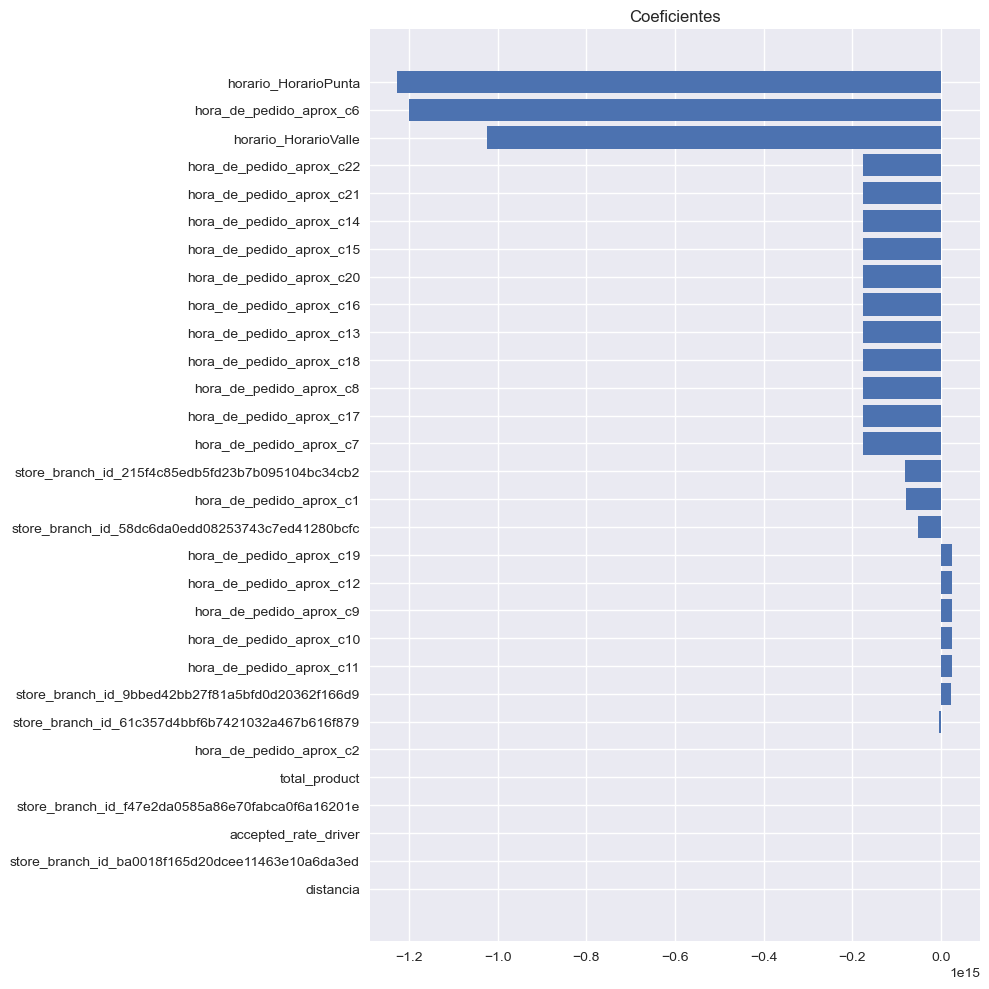

Comienza entrenamiento modelo variables relevantes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Resultados grilla modelo depurado

 The best estimator across ALL searched params:
 LinearRegression()

 The best score across ALL searched params:
 0.24806309263241447

 The best parameters across ALL searched params:
 {}

 The coeficiente de determinación  de la predicción across ALL searched params:
 -1.6145759840200412e+16

Resultados modelo con todas las variables...
El error cuadrático medio es 3891612697228688664559616.00, mientras que su raiz es 1972717084943.68
El error absoluto mediano es 13.53

Resultados modelo depurado.
El error cuadrático medio es 16495430134697254912.00, mientras que su raiz es 4061456651.83
El error absoluto mediano es 14.09


In [42]:
df_pred2, variables_relevantes_lr2 = fit_or_load_model(X_train2, X_test2, y_train2, y_test2, model_lr2,
                                                grid = grid_lr, fit_or_load = 'fit', con_outliers = False)

Cargando modelos guardados...


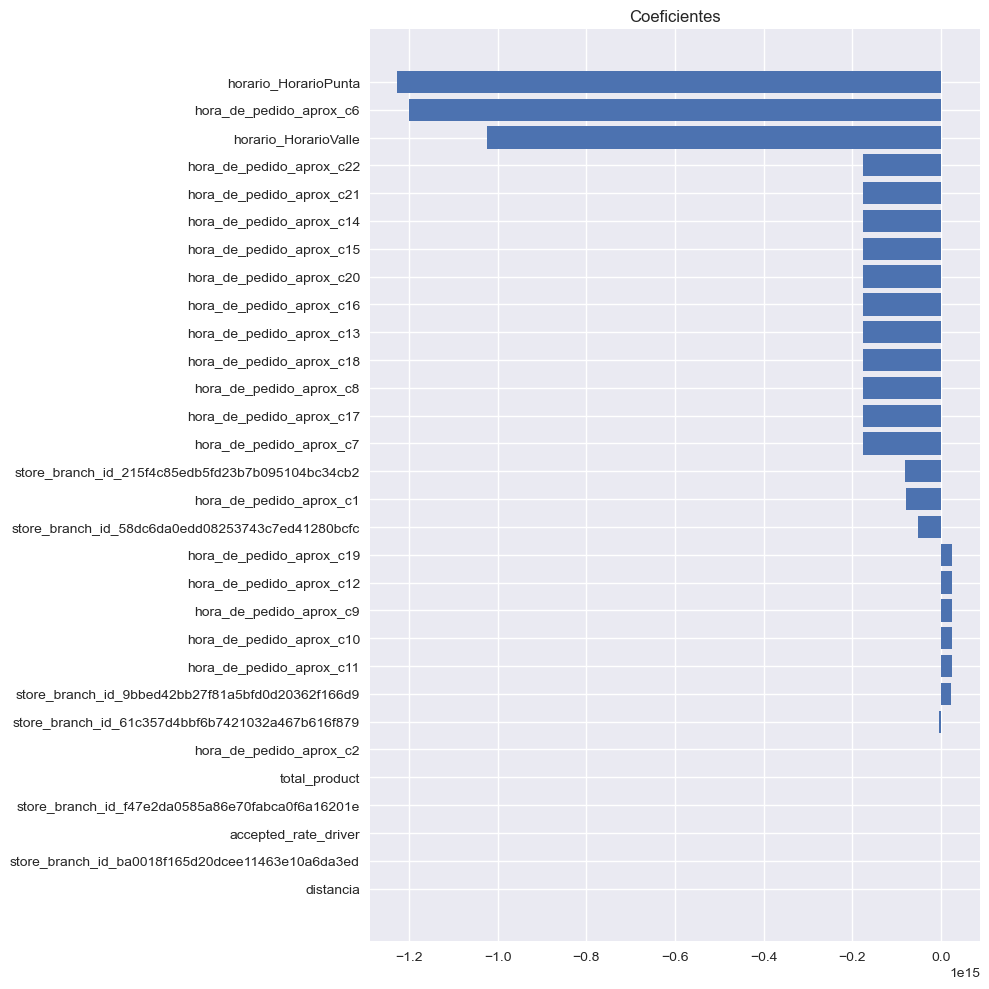


Resultados modelo con todas las variables...
El error cuadrático medio es 3891612697228688664559616.00, mientras que su raiz es 1972717084943.68
El error absoluto mediano es 13.53

Resultados modelo depurado.
El error cuadrático medio es 16495430134697254912.00, mientras que su raiz es 4061456651.83
El error absoluto mediano es 14.09


In [43]:
df_pred2, variables_relevantes_lr2 = fit_or_load_model(X_train2, X_test2, y_train2, y_test2, model_lr2,
                                                grid = grid_lr, fit_or_load = 'load', con_outliers = False)

In [44]:
orders_test2 = pd.concat([orders_test2, df_pred2], axis = 1)
orders_test2.head()

,order_id,LinearRegression_so,LinearRegression_dep_so
0,9f26ff0c67d37dec92f43b0c432d4b55,69.25,52.664062
1,71b0585100c4355bcaadc911fc132224,76.00,88.335938
2,0f59160b7589a1cf34e79b594465bc55,112.25,115.726562
3,cf0e584e31cb0882de8b9a1f73553dcf,80.75,81.960938
4,bcb6decc302198cc77e1b6e6530779e7,99.50,92.386719


**Comentarios**  
El comportamiento es el esperado, errores medianos absolutos menores. El error cuadrático medio sigue siendo muy alto, pero nuevamente se debe a predicciones específicas muy escapadas.

### 2. Elastic Net

In [45]:
grid_en2 = {
    'l1_ratio':[.1, .5, .7, .9, .95, .99, 1],
    'n_alphas': [1, 10, 100, 500, 1000,1500,2000]
    }

model_en2 = ElasticNetCV(max_iter = 10000, random_state = 42)

Comienza entrenamiento modelo con todas las variables...
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Resultados grilla

 The best estimator across ALL searched params:
 ElasticNetCV(l1_ratio=0.95, max_iter=10000, n_alphas=10, random_state=42)

 The best score across ALL searched params:
 0.2738377605210962

 The best parameters across ALL searched params:
 {'l1_ratio': 0.95, 'n_alphas': 10}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.268198383075403
Comienza identificación de top n variables relevantes...


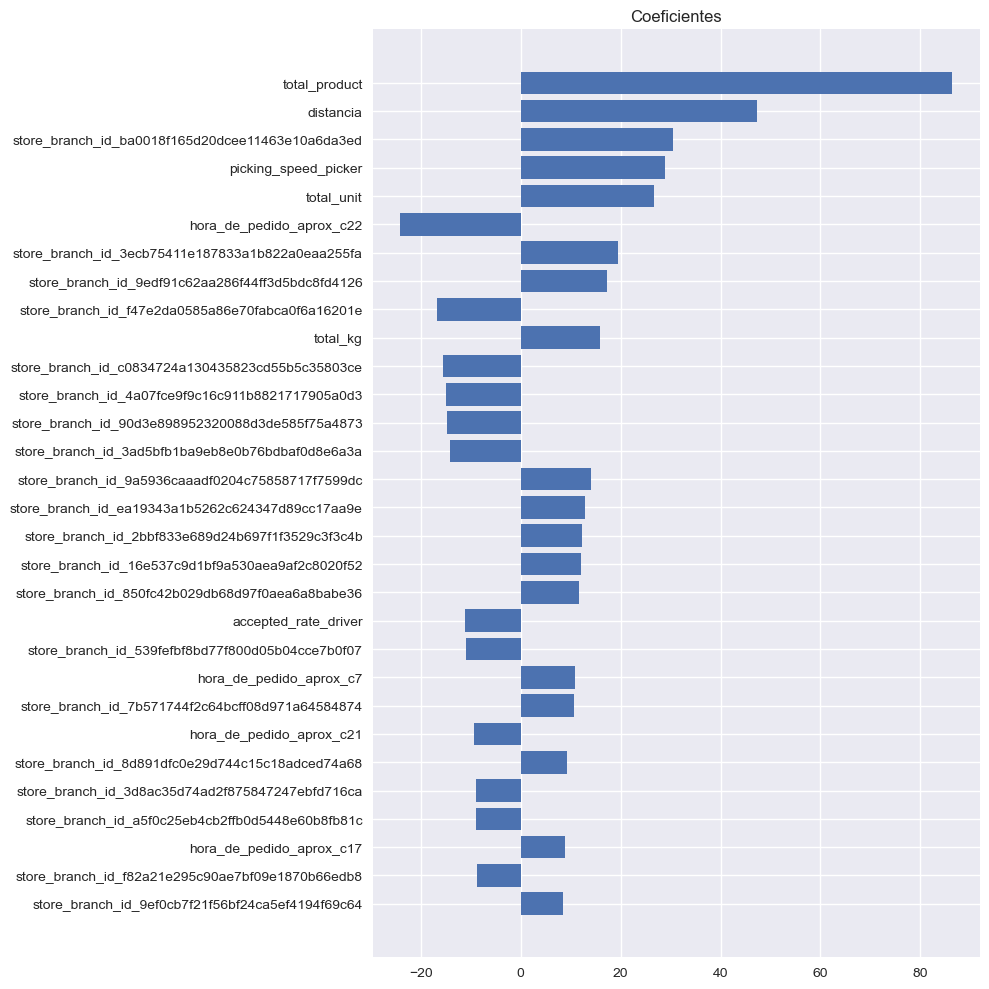

Comienza entrenamiento modelo variables relevantes...
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Resultados grilla modelo depurado

 The best estimator across ALL searched params:
 ElasticNetCV(l1_ratio=0.95, max_iter=10000, n_alphas=1, random_state=42)

 The best score across ALL searched params:
 0.27483606016515144

 The best parameters across ALL searched params:
 {'l1_ratio': 0.95, 'n_alphas': 1}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.25196870714287734

Resultados modelo con todas las variables...
El error cuadrático medio es 747.65, mientras que su raiz es 27.34
El error absoluto mediano es 13.25

Resultados modelo depurado.
El error cuadrático medio es 764.23, mientras que su raiz es 27.64
El error absoluto mediano es 13.48


In [46]:
df_pred2, variables_relevantes_en2 = fit_or_load_model(X_train2, X_test2, y_train2, y_test2, model_en2,
                                                grid = grid_en2, fit_or_load = 'fit', con_outliers = False)

Cargando modelos guardados...


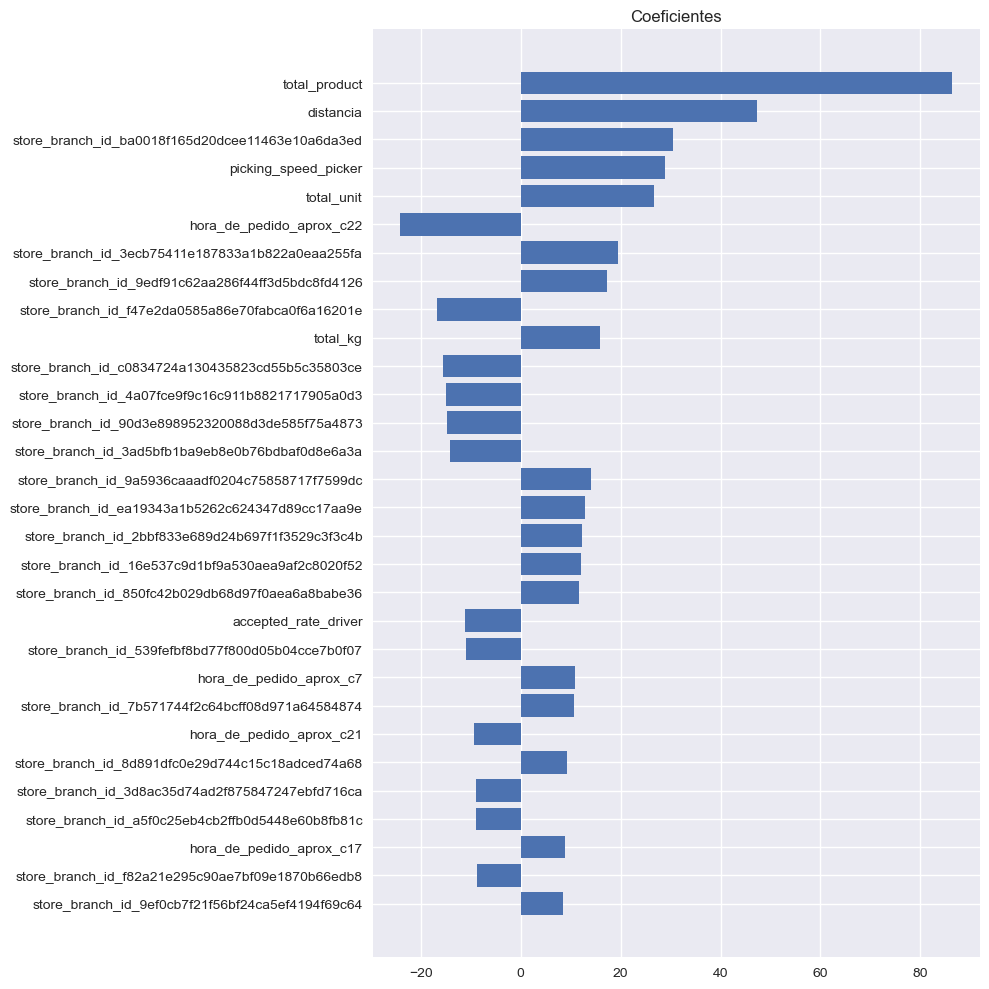


Resultados modelo con todas las variables...
El error cuadrático medio es 747.65, mientras que su raiz es 27.34
El error absoluto mediano es 13.25

Resultados modelo depurado.
El error cuadrático medio es 764.23, mientras que su raiz es 27.64
El error absoluto mediano es 13.48


In [47]:
df_pred2, variables_relevantes_en2 = fit_or_load_model(X_train2, X_test2, y_train2, y_test2, model_en2,
                                                grid = grid_en2, fit_or_load = 'load', con_outliers = False)

In [48]:
orders_test2 = pd.concat([orders_test2, df_pred2], axis = 1)
orders_test2.head()

,order_id,LinearRegression_so,LinearRegression_dep_so,ElasticNetCV_so,ElasticNetCV_dep_so
0,9f26ff0c67d37dec92f43b0c432d4b55,69.25,52.664062,67.194670,73.524025
1,71b0585100c4355bcaadc911fc132224,76.00,88.335938,90.061784,95.393488
2,0f59160b7589a1cf34e79b594465bc55,112.25,115.726562,111.184059,117.701056
3,cf0e584e31cb0882de8b9a1f73553dcf,80.75,81.960938,79.539796,78.642987
4,bcb6decc302198cc77e1b6e6530779e7,99.50,92.386719,98.765012,92.765184


**Comentarios**  
La relación entre el modelo depurado y el modelo Full se mantiene del caso sin outliers. En ese sentido, es lo esperable. Lo que llama la atención es la baja que existe en error cuadrático medo a la hora de sacar los outliers. Mientras que el modelo cuadrático medio ronda los 2000 minutos cuadrados en el modelo con outliers, en este caso disminuye a poco más de un tercio.

### 3. SGDRegressor

In [49]:
grid_sgd2 = {
    'loss': ['epsilon_insensitive'],
    'l1_ratio':[.1, .5, .7, .9, .95, .99, 1],
    'alpha': [0.0001, 0.001, 0.01,0.1]
    }

model_sgd2 = SGDRegressor(max_iter=1000, tol=1e-5)

Comienza entrenamiento modelo con todas las variables...
Fitting 5 folds for each of 28 candidates, totalling 140 fits


C:\Users\jahof\anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Resultados grilla

 The best estimator across ALL searched params:
 SGDRegressor(l1_ratio=0.1, loss='epsilon_insensitive', tol=1e-05)

 The best score across ALL searched params:
 0.22596064820331252

 The best parameters across ALL searched params:
 {'alpha': 0.0001, 'l1_ratio': 0.1, 'loss': 'epsilon_insensitive'}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.23575084122970424
Comienza identificación de top n variables relevantes...


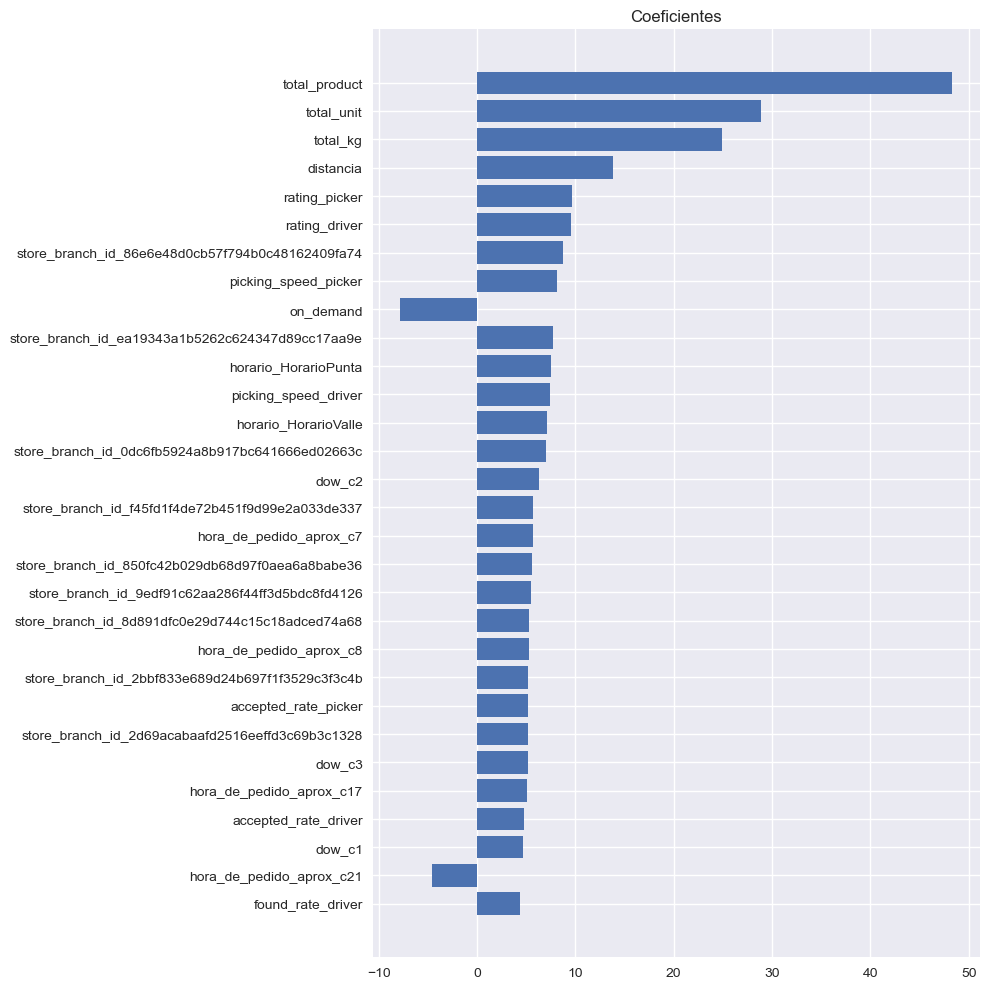

Comienza entrenamiento modelo variables relevantes...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Resultados grilla modelo depurado

 The best estimator across ALL searched params:
 SGDRegressor(l1_ratio=0.95, loss='epsilon_insensitive', tol=1e-05)

 The best score across ALL searched params:
 0.22774677472126253

 The best parameters across ALL searched params:
 {'alpha': 0.0001, 'l1_ratio': 0.95, 'loss': 'epsilon_insensitive'}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.23291105376954413

Resultados modelo con todas las variables...
El error cuadrático medio es 780.80, mientras que su raiz es 27.94
El error absoluto mediano es 14.36

Resultados modelo depurado.
El error cuadrático medio es 783.70, mientras que su raiz es 27.99
El error absoluto mediano es 14.54


C:\Users\jahof\anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [50]:
df_pred2, variables_relevantes_sgd2 = fit_or_load_model(X_train2, X_test2, y_train2, y_test2, model_sgd2,
                                                grid = grid_sgd2, fit_or_load = 'fit', con_outliers = False)

Cargando modelos guardados...


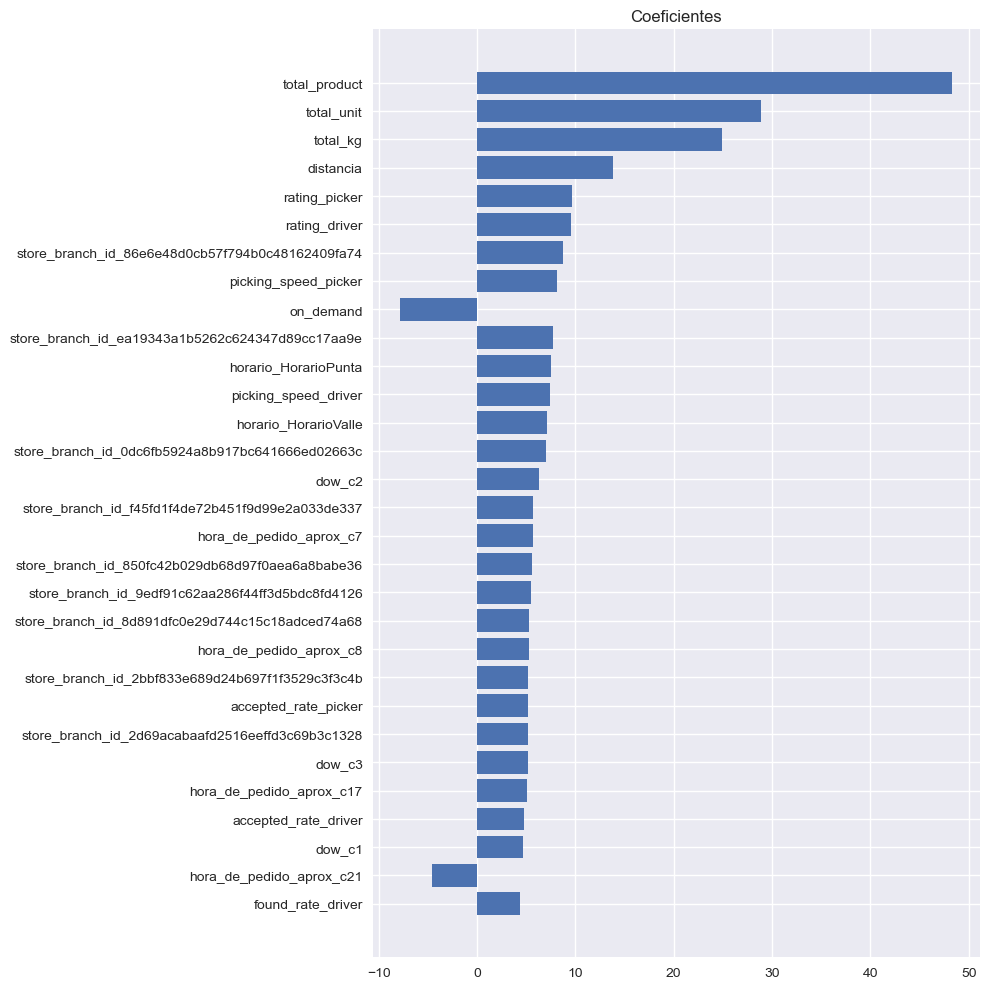


Resultados modelo con todas las variables...
El error cuadrático medio es 780.80, mientras que su raiz es 27.94
El error absoluto mediano es 14.36

Resultados modelo depurado.
El error cuadrático medio es 783.70, mientras que su raiz es 27.99
El error absoluto mediano es 14.54


In [51]:
df_pred2, variables_relevantes_sgd2 = fit_or_load_model(X_train2, X_test2, y_train2, y_test2, model_sgd2,
                                                grid = grid_sgd2, fit_or_load = 'load', con_outliers = False)

In [52]:
orders_test2 = pd.concat([orders_test2, df_pred2], axis = 1)
orders_test2.head()

,order_id,LinearRegression_so,LinearRegression_dep_so,ElasticNetCV_so,ElasticNetCV_dep_so,SGDRegressor_so,SGDRegressor_dep_so
0,9f26ff0c67d37dec92f43b0c432d4b55,69.25,52.664062,67.194670,73.524025,67.510091,67.336202
1,71b0585100c4355bcaadc911fc132224,76.00,88.335938,90.061784,95.393488,88.802453,88.513097
2,0f59160b7589a1cf34e79b594465bc55,112.25,115.726562,111.184059,117.701056,103.858174,104.366845
3,cf0e584e31cb0882de8b9a1f73553dcf,80.75,81.960938,79.539796,78.642987,87.279187,87.153162
4,bcb6decc302198cc77e1b6e6530779e7,99.50,92.386719,98.765012,92.765184,104.903183,104.814123


**Comentarios**  
El caso SGD está en la misma línea que EN, disminuyendo notablemente el error cuadrático medio. Pasa de cerca de 4600 minutos cuadrados en el modelo con outliers a 780 minutos cuadrados en este nuevo modelo. 

### 4. GradientBoostingRegressor

In [53]:
grid_gbr2 = {
'learning_rate': [0.01, 0.1, 0.5],
'n_estimators': [50, 100, 500, 1000, 2000],
'subsample': [0.1,0.5,0.9, 1]
}

model_gb2 = GradientBoostingRegressor(random_state = 42)

Comienza entrenamiento modelo con todas las variables...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Resultados grilla

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, n_estimators=2000,
                          random_state=42, subsample=0.9)

 The best score across ALL searched params:
 0.2872454167589674

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'n_estimators': 2000, 'subsample': 0.9}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.27480250090851444
Comienza identificación de top n variables relevantes...


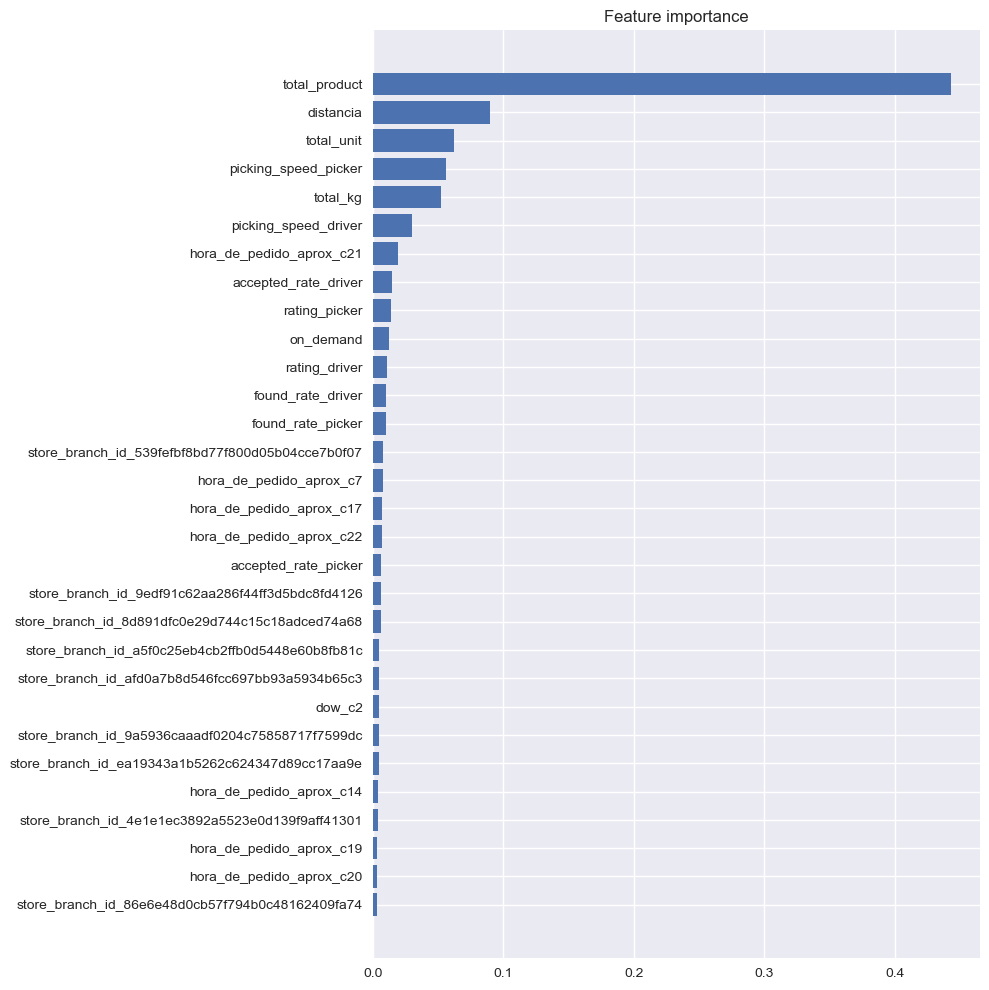

Comienza entrenamiento modelo variables relevantes...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Resultados grilla modelo depurado

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000,
                          random_state=42, subsample=0.5)

 The best score across ALL searched params:
 0.28362926770230124

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.5}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.27081033147594336

Resultados modelo con todas las variables...
El error cuadrático medio es 740.90, mientras que su raiz es 27.22
El error absoluto mediano es 12.83

Resultados modelo depurado.
El error cuadrático medio es 744.98, mientras que su raiz es 27.29
El error absoluto mediano es 12.90


In [54]:
df_pred2, variables_relevantes_gb2 = fit_or_load_model(X_train2, X_test2, y_train2, y_test2, model_gb2,
                                                grid = grid_gbr2, fit_or_load = 'fit', con_outliers = False)

Cargando modelos guardados...


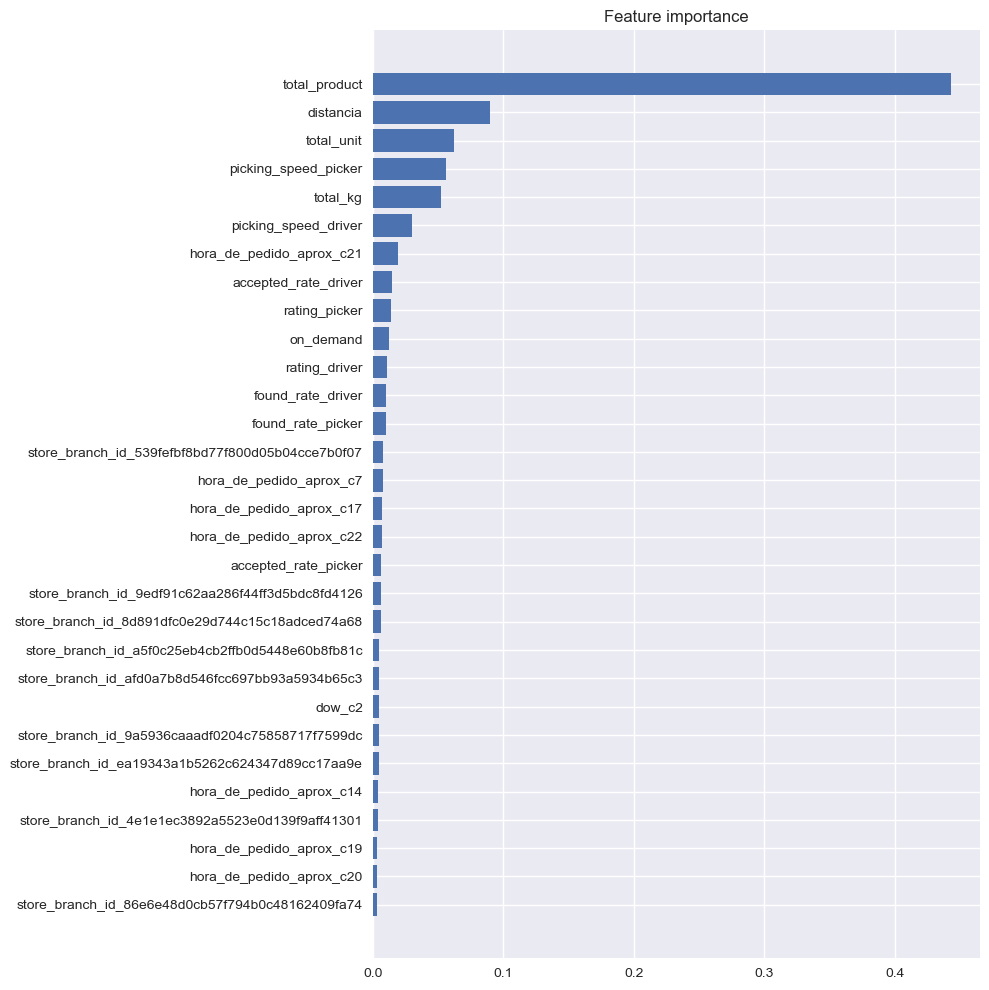


Resultados modelo con todas las variables...
El error cuadrático medio es 740.90, mientras que su raiz es 27.22
El error absoluto mediano es 12.83

Resultados modelo depurado.
El error cuadrático medio es 744.98, mientras que su raiz es 27.29
El error absoluto mediano es 12.90


In [55]:
df_pred2, variables_relevantes_gb2 = fit_or_load_model(X_train2, X_test2, y_train2, y_test2, model_gb2,
                                                grid = grid_gbr2, fit_or_load = 'load', con_outliers = False)

In [56]:
orders_test2 = pd.concat([orders_test2, df_pred2], axis = 1)
orders_test2.head()

,order_id,LinearRegression_so,LinearRegression_dep_so,ElasticNetCV_so,ElasticNetCV_dep_so,SGDRegressor_so,SGDRegressor_dep_so,GradientBoostingRegressor_so,GradientBoostingRegressor_dep_so
0,9f26ff0c67d37dec92f43b0c432d4b55,69.25,52.664062,67.194670,73.524025,67.510091,67.336202,53.955739,57.484410
1,71b0585100c4355bcaadc911fc132224,76.00,88.335938,90.061784,95.393488,88.802453,88.513097,98.282884,100.383193
2,0f59160b7589a1cf34e79b594465bc55,112.25,115.726562,111.184059,117.701056,103.858174,104.366845,115.376360,118.988620
3,cf0e584e31cb0882de8b9a1f73553dcf,80.75,81.960938,79.539796,78.642987,87.279187,87.153162,82.504870,81.642304
4,bcb6decc302198cc77e1b6e6530779e7,99.50,92.386719,98.765012,92.765184,104.903183,104.814123,100.879492,102.519856


**Comentarios**  
Este modelo sin outliers también tiene una notable mejora en lo que es error cuadrático medio. Sin embargo, es aun más destacable que su error mediano absoluto baja de los 13 minutos. Es un rendimiento incluso mejor que el ElasticNet. Así, vemos que Gradient Boosting en este problema tiene mejor comportamiento en la medida que hay menos outliers.


### 5. RandomForestRegressor

In [57]:
grid_rf2 = {"n_estimators": [10, 50, 100],
           "criterion": ['squared_error'],
           "max_depth":  np.linspace(2,32, dtype=int, num=4) , # genero el maximo de profundidad entre 1 y 32
           "max_features": list(range(7, X_train.shape[1]+1)) #genero maximo atributos, genero un rango pero lo envuelvo en una lista desde 1 a la cantidad de columnas
           }

model_rf2 = RandomForestRegressor(random_state = 42)


Comienza entrenamiento modelo con todas las variables...
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Resultados grilla

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=32, max_features=12, random_state=42)

 The best score across ALL searched params:
 0.2734833394690291

 The best parameters across ALL searched params:
 {'criterion': 'squared_error', 'max_depth': 32, 'max_features': 12, 'n_estimators': 100}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.2551784768408595
Comienza identificación de top n variables relevantes...


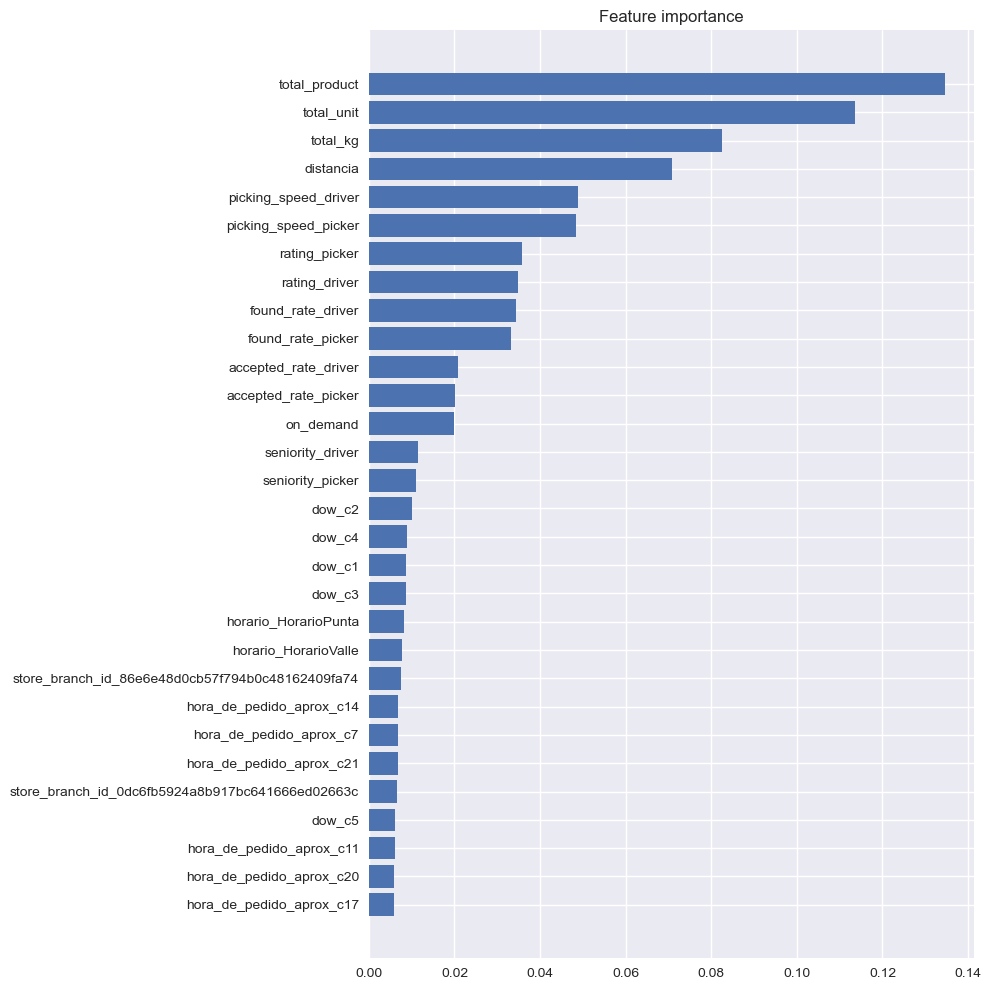

Comienza entrenamiento modelo variables relevantes...
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Resultados grilla modelo depurado

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=12, max_features=8, random_state=42)

 The best score across ALL searched params:
 0.26426109858044644

 The best parameters across ALL searched params:
 {'criterion': 'squared_error', 'max_depth': 12, 'max_features': 8, 'n_estimators': 100}

 The coeficiente de determinación  de la predicción across ALL searched params:
 0.2448756036045392

Resultados modelo con todas las variables...
El error cuadrático medio es 760.95, mientras que su raiz es 27.59
El error absoluto mediano es 13.52

Resultados modelo depurado.
El error cuadrático medio es 771.48, mientras que su raiz es 27.78
El error absoluto mediano es 13.08


In [58]:
df_pred2, variables_relevantes_rf2 = fit_or_load_model(X_train2, X_test2, y_train2, y_test2, model_rf2,
                                                grid = grid_rf2, fit_or_load = 'fit', con_outliers = False)

Cargando modelos guardados...


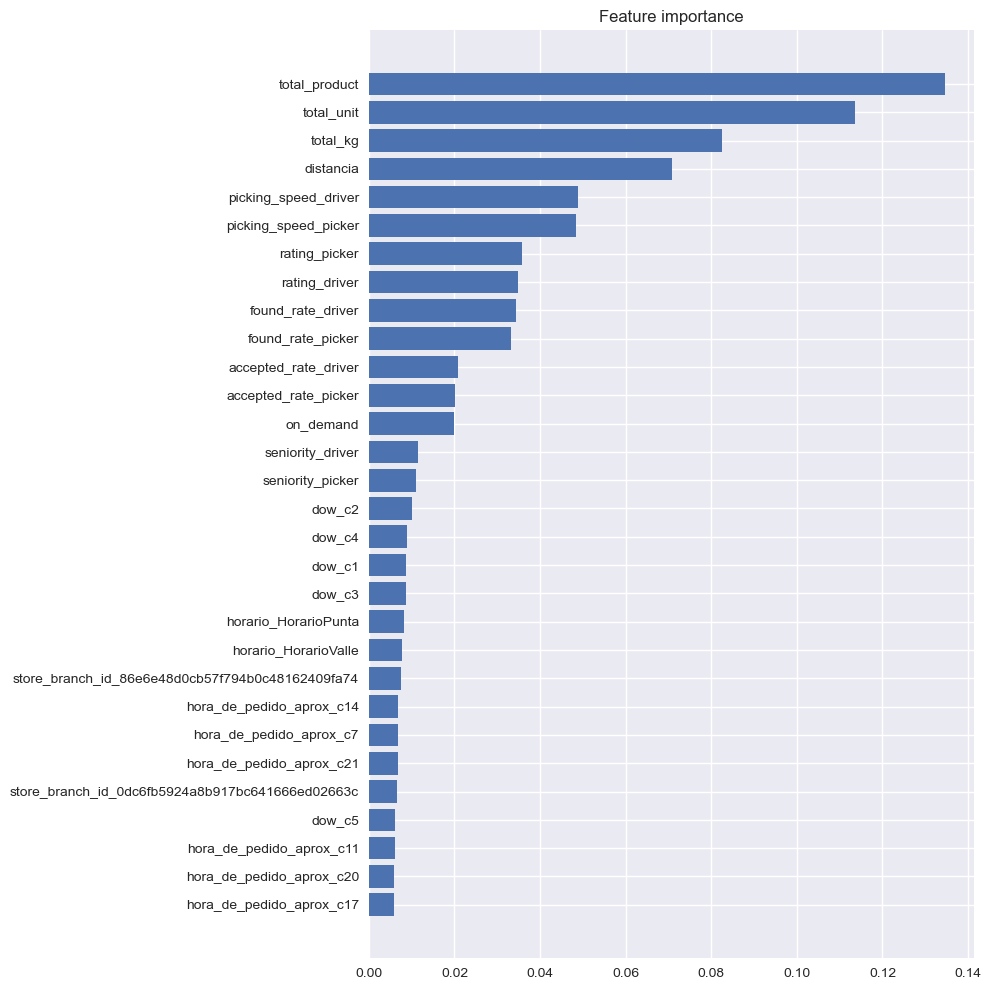


Resultados modelo con todas las variables...
El error cuadrático medio es 760.95, mientras que su raiz es 27.59
El error absoluto mediano es 13.52

Resultados modelo depurado.
El error cuadrático medio es 771.48, mientras que su raiz es 27.78
El error absoluto mediano es 13.08


In [59]:
df_pred2, variables_relevantes_rf2 = fit_or_load_model(X_train2, X_test2, y_train2, y_test2, model_rf2,
                                                grid = grid_rf2, fit_or_load = 'load', con_outliers = False)

In [60]:
orders_test2 = pd.concat([orders_test2, df_pred2], axis = 1)
orders_test2.head()

,order_id,LinearRegression_so,LinearRegression_dep_so,ElasticNetCV_so,ElasticNetCV_dep_so,SGDRegressor_so,SGDRegressor_dep_so,GradientBoostingRegressor_so,GradientBoostingRegressor_dep_so,RandomForestRegressor_so,RandomForestRegressor_dep_so
0,9f26ff0c67d37dec92f43b0c432d4b55,69.25,52.664062,67.194670,73.524025,67.510091,67.336202,53.955739,57.484410,53.220758,56.172366
1,71b0585100c4355bcaadc911fc132224,76.00,88.335938,90.061784,95.393488,88.802453,88.513097,98.282884,100.383193,95.792620,104.303392
2,0f59160b7589a1cf34e79b594465bc55,112.25,115.726562,111.184059,117.701056,103.858174,104.366845,115.376360,118.988620,107.609719,111.604138
3,cf0e584e31cb0882de8b9a1f73553dcf,80.75,81.960938,79.539796,78.642987,87.279187,87.153162,82.504870,81.642304,89.621773,89.068572
4,bcb6decc302198cc77e1b6e6530779e7,99.50,92.386719,98.765012,92.765184,104.903183,104.814123,100.879492,102.519856,104.836292,105.765323


**Comentarios**  
Por último, el random forest presenta un comportamiento bastante similar y ya es lo esperado. De modo que a continuación se analizará el rendimiento de los modelos por día de la semana y por horario.

## Analizando errores modelos sin outliers

In [61]:
# Genero la lista de modelos sin outliers
lista_modelos2 = list(orders_test2.columns)
lista_modelos2.remove('order_id')
lista_modelos2 = ['modelo_campeon'] + lista_modelos2 
lista_modelos2

['modelo_campeon',
 'LinearRegression_so',
 'LinearRegression_dep_so',
 'ElasticNetCV_so',
 'ElasticNetCV_dep_so',
 'SGDRegressor_so',
 'SGDRegressor_dep_so',
 'GradientBoostingRegressor_so',
 'GradientBoostingRegressor_dep_so',
 'RandomForestRegressor_so',
 'RandomForestRegressor_dep_so']

In [62]:
df_result2 = pd.merge(df, orders_test2, how='inner', left_on = 'order_id', right_on = 'order_id', suffixes = ('_order', '_store'))
with pd.option_context("display.max_columns", None):
    display(df_result2.head(n = 5))

,order_id,lat_order,lng_order,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes,actual_reception_time,promised_delivery_time,total_minutes_td,order_time,model_1_dt_time,model_1_time,store,lat_store,lng_store,shopper_id_picker,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,shopper_id_driver,seniority_driver,found_rate_driver,picking_speed_driver,accepted_rate_driver,rating_driver,total_product,real_total_unit,real_total_kg,real_without_product,total_unit,total_kg,distancia,hora_de_pedido_aprox,horario,LinearRegression_so,LinearRegression_dep_so,ElasticNetCV_so,ElasticNetCV_dep_so,SGDRegressor_so,SGDRegressor_dep_so,GradientBoostingRegressor_so,GradientBoostingRegressor_dep_so,RandomForestRegressor_so,RandomForestRegressor_dep_so
0,528428e9b9eb5d3bd0dbdd8da692b087,18.26683,-10.03175,2,11:00:00,10:40:50,False,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458001,1900-01-01 10:40:50,1900-01-01 11:00:00,0 days 01:33:27.480060,1900-01-01 09:07:22.519940000,0 days 01:52:37.480060,112.624668,0fae7b61265bc7ca4ce4d81440b62501,18.24565,-10.03324,e15c7a67d0ea9a54dffb410bc1d8528b,INTERMEDIATE,0.83,2.03,1.00,4.96,e15c7a67d0ea9a54dffb410bc1d8528b,INTERMEDIATE,0.83,2.03,1.00,4.96,6.0,6.0,0.0,0.0,6.0,0.0,2.360362,9,HorarioPunta,77.25,69.199219,77.110331,73.887613,82.132472,82.799535,74.066324,73.550802,83.662706,71.496575
1,f169a660e8667798da11775767cdce78,18.28933,-10.03227,2,12:00:00,11:29:36,False,163278a2f745b3416526066a5fe12f3b,163278a2f745b3416526066a5fe12f3b,86e6e48d0cb57f794b0c48162409fa74,74.993118,1900-01-01 11:29:36,1900-01-01 12:00:00,0 days 01:14:59.587079999,1900-01-01 10:14:36.412920001,0 days 01:45:23.587079999,105.393118,60e4c4e1c1a8bc79123738227b9d0b08,18.29988,-10.03484,163278a2f745b3416526066a5fe12f3b,INTERMEDIATE,0.85,2.33,0.96,4.64,163278a2f745b3416526066a5fe12f3b,INTERMEDIATE,0.85,2.33,0.96,4.64,2.0,4.0,0.0,0.0,4.0,0.0,1.204077,10,HorarioPunta,70.00,60.898438,69.435289,61.830467,80.310650,79.777605,59.174106,61.278507,60.683019,57.683723
2,e330962281e3de49b3d3856653e6da71,18.30324,-10.03444,2,11:00:00,10:22:00,False,29c7a131083ab05e25a3d9b4d49d8c5e,29c7a131083ab05e25a3d9b4d49d8c5e,a3bed30221372366bcd9b9779f395d0b,87.612301,1900-01-01 10:22:00,1900-01-01 11:00:00,0 days 01:27:36.738060,1900-01-01 08:54:23.261940000,0 days 02:05:36.738060,125.612301,451eb58b96f0a36f31d2beebd1c9a7a8,18.30272,-10.03446,29c7a131083ab05e25a3d9b4d49d8c5e,INTERMEDIATE,0.83,1.81,1.00,4.72,29c7a131083ab05e25a3d9b4d49d8c5e,INTERMEDIATE,0.83,1.81,1.00,4.72,15.0,21.0,0.0,1.0,22.0,0.0,0.057860,8,HorarioValle,79.00,77.257812,79.255640,70.169355,84.291818,84.305005,77.110540,73.767952,75.361495,76.982625
3,4211ea0cba325e47bb71b7fed552d9c4,18.26840,-10.03124,2,9:00:00,8:28:39,False,8a7dc2f6cfa12b8f6514043aaf5e5bc7,8a7dc2f6cfa12b8f6514043aaf5e5bc7,f45fd1f4de72b451f9d99e2a033de337,88.363666,1900-01-01 08:28:39,1900-01-01 09:00:00,0 days 01:28:21.819960,1900-01-01 07:00:17.180040000,0 days 01:59:42.819960,119.713666,387d4a5b65cf4bf00ad805c4b00eed01,18.22698,-10.03056,8a7dc2f6cfa12b8f6514043aaf5e5bc7,ADVANCED,0.88,1.32,1.00,4.92,8a7dc2f6cfa12b8f6514043aaf5e5bc7,ADVANCED,0.88,1.32,1.00,4.92,3.0,31.0,0.0,0.0,40.0,0.0,4.606260,7,HorarioValle,83.00,82.007812,83.137488,77.890693,91.555914,91.788739,76.695256,76.106105,84.966734,67.270972
4,f28062e9d0b9d4cfa1a44d248b9c5e84,18.22146,-10.03281,2,11:00:00,10:02:37,False,b49ed2d763e39e6834e0f5f35c754132,b49ed2d763e39e6834e0f5f35c754132,850fc42b029db68d97f0aea6a8babe36,69.157783,1900-01-01 10:02:37,1900-01-01 11:00:00,0 days 01:09:09.466979999,1900-01-01 08:53:27.533020001,0 days 02:06:32.466979999,126.541116,387d4a5b65cf4bf00ad805c4b00eed01,18.23036,-10.03179,b49ed2d763e39e6834e0f5f35c754132,INTERMEDIATE,0.90,2.47,1.00,4.80,b49ed2d763e39e6834e0f5f35c754132,INTERMEDIATE,0.90,2.47,1.00,4.80,8.0,7.0,0.0,1.0,8.0,0.0,0.995482,8,HorarioValle,88.25,71.808594,87.113955,77.272860,89.189813,

In [63]:
  
columnas_drop = ['order_id', 'lat_order', 'lng_order', 
        'on_demand', 'picker_id', 'driver_id', 'store_branch_id',
       'actual_reception_time', 'promised_delivery_time',
       'total_minutes_td', 'order_time', 'model_1_dt_time',
       'store', 'lat_store', 'lng_store', 'shopper_id_picker',
       'seniority_picker', 'found_rate_picker', 'picking_speed_picker',
       'accepted_rate_picker', 'rating_picker', 'shopper_id_driver',
       'seniority_driver', 'found_rate_driver', 'picking_speed_driver',
       'accepted_rate_driver', 'rating_driver', 'total_product',
       'real_total_unit', 'real_total_kg', 'real_without_product',
       'total_unit', 'total_kg', 'distancia']

df_analisis2 = df_result2.copy().drop(columns = columnas_drop)
df_analisis2 = df_analisis2.rename(columns={'model_1_time': 'modelo_campeon'})
df_analisis2.head()

,dow,promised_time,actual_time,total_minutes,modelo_campeon,hora_de_pedido_aprox,horario,LinearRegression_so,LinearRegression_dep_so,ElasticNetCV_so,ElasticNetCV_dep_so,SGDRegressor_so,SGDRegressor_dep_so,GradientBoostingRegressor_so,GradientBoostingRegressor_dep_so,RandomForestRegressor_so,RandomForestRegressor_dep_so
0,2,11:00:00,10:40:50,93.458001,112.624668,9,HorarioPunta,77.25,69.199219,77.110331,73.887613,82.132472,82.799535,74.066324,73.550802,83.662706,71.496575
1,2,12:00:00,11:29:36,74.993118,105.393118,10,HorarioPunta,70.00,60.898438,69.435289,61.830467,80.310650,79.777605,59.174106,61.278507,60.683019,57.683723
2,2,11:00:00,10:22:00,87.612301,125.612301,8,HorarioValle,79.00,77.257812,79.255640,70.169355,84.291818,84.305005,77.110540,73.767952,75.361495,76.982625
3,2,9:00:00,8:28:39,88.363666,119.713666,7,HorarioValle,83.00,82.007812,83.137488,77.890693,91.555914,91.788739,76.695256,76.106105,84.966734,67.270972
4,2,11:00:00,10:02:37,69.157783,126.541116,8,HorarioValle,88.25,71.808594,87.113955,77.272860,89.189813,89.578168,73.627620,68.817196,77.006716,67.978731


In [64]:
# Gero el reporte sin outliers    
report_hra2 = pd.concat([
    calcular_error_modelo(df_analisis2, model_i, 'horario') for model_i in lista_modelos2
],
axis = 0)
report_hra2.astype(float).to_csv('report_so_hra2.csv', sep = ';', decimal = ',')

report_hra2#.drop(index = ['LinearRegression_ErrorCuadraticoMedio', 'LinearRegression_dep_ErrorCuadraticoMedio'])


horario,HorarioNocturno,HorarioPunta,HorarioValle
modelo_campeon_ErrorMedianoAbsoluto,58.533333,36.266667,33.533333
modelo_campeon_ErrorCuadraticoMedio,2493.551296,2042.805647,1785.425283
LinearRegression_so_ErrorMedianoAbsoluto,20.524381,13.334066,13.735821
LinearRegression_so_ErrorCuadraticoMedio,772.765803,8605852298061244891398144.0,551346769752429485359104.0
LinearRegression_dep_so_ErrorMedianoAbsoluto,19.352506,14.09468,14.01837
LinearRegression_dep_so_ErrorCuadraticoMedio,798.304904,39765385031362748416.0,754.560592
ElasticNetCV_so_ErrorMedianoAbsoluto,19.488131,12.919447,13.354282
ElasticNetCV_so_ErrorCuadraticoMedio,543.281968,764.324066,736.366107
ElasticNetCV_dep_so_ErrorMedianoAbsoluto,20.455257,13.61735,13.319883
ElasticNetCV_dep_so_ErrorCuadraticoMedio,506.156514,781.908891,752.383148


**Comentarios**  
Nuevamente, se presenta el análisis según la tabla anterior y según un análisis independiente. 
- Al contrario del caso con modelos con outliers, ahora tanto en horario nocturno, horario punta y horario valle el modelo campeón es vencido. cabe destacar que el random forest depurado logra un error de solo 7 minutos en horario nocturno. Si bien son pocos datos, es batante interesante. El resto de los modelos consistentemente tiene errores menores a 20 minutos.
- En lo que es horario punta y horario valle, Gradient boosting Regressor y Elastic net presentan muy buenos resultados, con errores absolutos medianos entre 12 y 13 minutos.
- Para el error cuadrático medio, existe bastante consistencia entre todos los modelos, con errores entre 700 y 800 minutos cuadrados. Lo anterior vs 2000 minutos cuadrados del modelo campeón.

In [65]:
# Genero el reporte sin outliers
report_dow2 = pd.concat([
    calcular_error_modelo(df_analisis2, model_i, 'dow') for model_i in lista_modelos2
],
axis = 0)
report_dow2.astype(float).to_csv('report_so_dow2.csv', sep = ';', decimal = ',')

report_dow2.drop(index = ['LinearRegression_so_ErrorCuadraticoMedio', 'LinearRegression_dep_so_ErrorCuadraticoMedio'])


dow,0.0,1.0,2.0,3.0,4.0,5.0,6.0
modelo_campeon_ErrorMedianoAbsoluto,32.300000,38.533333,34.716667,38.400000,34.250000,28.375000,31.033333
modelo_campeon_ErrorCuadraticoMedio,1489.681573,2060.586606,1983.592646,2195.934216,1915.459885,1619.061516,1543.486410
LinearRegression_so_ErrorMedianoAbsoluto,13.481588,14.275442,13.432143,12.978074,12.834244,13.237534,15.197396
LinearRegression_dep_so_ErrorMedianoAbsoluto,15.056453,15.271983,13.373233,13.840366,14.313815,14.078169,11.794718
ElasticNetCV_so_ErrorMedianoAbsoluto,12.954854,13.573014,13.230029,12.677577,12.902645,14.102372,14.528082
ElasticNetCV_so_ErrorCuadraticoMedio,639.591095,841.862766,802.664616,771.850803,722.412785,720.011783,599.079380
ElasticNetCV_dep_so_ErrorMedianoAbsoluto,15.362523,15.205014,13.027992,13.391659,13.118889,13.750672,13.014662
ElasticNetCV_dep_so_ErrorCuadraticoMedio,710.413270,874.610447,791.782408,786.315560,734.548794,739.567738,599.327458
SGDRegressor_so_ErrorMedianoAbsoluto,13.704159,16.219895,15.228086,13.393172,13.877664,14.859286,12.468466
SGDRegressor_so_ErrorCuadraticoMedio,653.290199,895.641509,830.410229,791.761841,780.687522,777.081790,581.061420


**Comentarios**  
Nuevamente, todos los modelos desafiantes presentan un mejor rendimiento que el modelo campeón. Mientras el menor error absoluto mediano de este es el día sábado con 28 minutos, los modelos desafiantes no superan los 16 minutos de error. Nuevamente, los mejores rendimientos se observan en elastic net y gradient boosting regressor.